In [ ]:
from python.analysis.Utils import init_notebook
%init_notebook

from apps import cex_toy_generator, cex_toy_parameters, cex_fit_studies, cex_analyse
from IPython.display import clear_output
from python.analysis.Master import DictToHDF5, ReadHDF5
from python.analysis import cross_section, Plots
from scipy.stats import norm, lognorm
from statsmodels.stats.weightstats import ztest as ztest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rich import print
cross_section.PlotStyler.SetPlotStyle(True, dpi = 80)

def CreateConfig(PDSP : int = 1, p_init : float = 1000, events : int = 50805, seed : int = None, verbose : bool = False, modified_PDFs : dict[np.array] = None, scale_factors : dict[float] = None, smearing : str = "double_crystal_ball", step : float = 2):
    return {
    "events" : events,
    "step" : step,
    "p_init" : p_init,
    "beam_profile" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/beam_profile/beam_profile.json",
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_init/{smearing}.json",
        "KE_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int/{smearing}.json",
        "z_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/z_int/{smearing}.json"
    },
    "reco_region_fractions" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : scale_factors,
    "verbose" : verbose,
    "seed" : seed,
    "modified_PDFs" : modified_PDFs
    }


def RegionFitToyStudy(toy : cross_section.Toy, model : cross_section.pyhf.Model, energy_slice : cross_section.Slices, mean_track_score_bins : np.array = None, pdf : Plots.PlotBook = Plots.PlotBook.null, single_bin : bool = False):

    fit_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy)

    observed = cross_section.RegionFit.GenerateObservations(fit_input, energy_slice, mean_track_score_bins, model, single_bin = single_bin)
    result = cross_section.RegionFit.Fit(observed, model, False)

    postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = result)

    #* split post fit results by the observables
    if mean_track_score_bins is not None:
        KE_int_prediction = cross_section.RegionFit.SliceModelPrediction(postfit_pred, slice(-1), "KE_int_postfit")
    else:
        KE_int_prediction = postfit_pred

    total_count_err = np.sum(np.power(KE_int_prediction.total_stdev_model_channels, 2))**0.5
    total_count = np.sum(KE_int_prediction.model_yields)

    # Plot fitted correlation matrix and actual
    plot = Plots.MultiPlot(2)
    next(plot)
    counts_matrix = []
    for j in toy.truth_region_labels:
        counts = []
        for i in toy.reco_region_labels:
            counts.append(sum(toy.NInteract(energy_slice, toy.truth_regions[j], toy.reco_regions[i])))
        counts_matrix.append(counts)
    print(f"{counts_matrix=}")
    total_count_actual = np.sum(counts_matrix)
    Plots.PlotConfusionMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "actual", newFigure = False, x_label = "true process", y_label = "reco region")
    next(plot)
    counts_matrix = []
    for c in KE_int_prediction.model_yields:
        counts_matrix.append([sum(s) for s in c])
    counts_matrix = np.array(counts_matrix, dtype = int).T
    Plots.PlotConfusionMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "actual", newFigure = False, x_label = "true process", y_label = "reco region")

    print(f"{total_count_actual, total_count, total_count_err=}")

    pdf.Save()

    mu = {}
    for n in model.config.par_names:
        if "mu" in n:
            mu[f"${n}$"] = {"value" : result.bestfit[model.config.par_names.index(n)], "error" : result.uncertainty[model.config.par_names.index(n)]}
    mu = pd.DataFrame(mu)

    # Plot parameters of interest
    Plots.Plot(list(mu.columns), mu.iloc[0], yerr = mu.iloc[1], marker = "o", linestyle = "")
    Plots.plt.xticks(ticks = list(mu.columns), labels = list(mu.columns))
    pdf.Save()

    # Plot all fit parameters
    Plots.Plot(np.linspace(0, len(result.bestfit), len(result.bestfit)), result.bestfit, yerr = result.uncertainty, linestyle = "", marker = "o", markersize = 1, capsize = 2, xlabel = "fit parameter index", ylabel = "value")
    plt.ylim(0.75, 1.25)
    pdf.Save()

    # print table of parameters of interest
    print(mu.head())
    return result


def NormalisationFractionalError(results, true_counts, model, toy_template):
    true_counts_pred_res = {}
    true_counts_pred_res_err = {}
    for k, v in results.items():
        post_fit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = v, label = "post-fit")

        if any([c["name"] == "mean_track_score" for c in post_fit_pred.model.spec["channels"]]):
            post_fit_pred = cross_section.RegionFit.SliceModelPrediction(post_fit_pred, slice(-1), "KE_int_postfit") # exclude the channel which is the mean track score
        else:
            post_fit_pred = cross_section.RegionFit.SliceModelPrediction(post_fit_pred, slice(0, len(post_fit_pred.model_yields)), "KE_int_postfit")

        true_counts_pred_res_err[k] = np.sum(post_fit_pred.total_stdev_model_channels, 0)[:-1]
        true_counts_pred_res[k] = {toy_template.truth_region_labels[j] : int(np.sum([post_fit_pred.model_yields[i][j] for i in range(len(toy_template.reco_region_labels))])) - true_counts[k][toy_template.truth_region_labels[j]] for j in range(len(toy_template.truth_region_labels))}

    true_counts = pd.DataFrame(true_counts)
    true_counts_pred_res = pd.DataFrame(true_counts_pred_res)
    true_counts_pred_res_err = pd.DataFrame(true_counts_pred_res_err, index = true_counts_pred_res.index)

    return true_counts_pred_res / true_counts, true_counts_pred_res_err / true_counts


def BSFractionalError(model : cross_section.pyhf.Model, toy_template, fit_results, signal_process : str):
    b_fe = []
    b_fe_err = []
    s_fe = []
    s_fe_err = []
    for r in fit_results["results"]:
        bkg, bkg_var = cross_section.RegionFit.EstimateBackgroundAllRegions(fit_results["results"][r], model, toy_template, signal_process)    
        b_tc = sum([sum(v) for k, v in fit_results["true_counts"][r].items() if k != signal_process])
        
        b_fe.append((sum(bkg) - b_tc) / b_tc)
        b_fe_err.append(np.sqrt(sum(bkg_var)) / b_tc)

        n_total = sum([sum(v) for v in fit_results["true_counts"][r].values()])
        n_s = n_total - sum(bkg)
        n_s_err = np.sqrt(n_total + sum(bkg_var))
        s_tc = sum(fit_results["true_counts"][r][signal_process])

        s_fe.append((n_s - s_tc) / s_tc)
        s_fe_err.append(n_s_err / s_tc)

    return (s_fe, s_fe_err), (b_fe, b_fe_err)

env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [2]:
toy_template = cross_section.Toy(file = "work/2023/toys/xs_toy_2GeV_cb_2cm_template.hdf5")
ai_template = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template)

In [3]:
energy_range = [1100, 2000]
energy_slice = cross_section.Slices(100, min(energy_range), max(energy_range), True)

In [3]:
energy_overflow = energy_slice.pos_overflow
energy_bins = energy_slice.pos_bins

mean_track_score_bins = np.linspace(0, 1, 21, True)

_, templates_energy, tempalates_mean_track_score = cross_section.RegionFit.CreateModel(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template), energy_slice, mean_track_score_bins, True, None, False, False)
models = {
    "normal" : cross_section.RegionFit.CreateModel(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template), energy_slice, None, False, None, False),
    "track_score" : cross_section.RegionFit.CreateModel(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template), energy_slice, mean_track_score_bins, False, None, False)
    }

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 15, 'channel_1': 15, 'channel_2': 15, 'channel_3': 15, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []
  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 15, 'channel_1': 15, 'channel_2': 15, 'channel_3': 15}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []
  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 15, 'channel_1': 15, 'channel_2': 15, 'channel_3': 15, 'mean_trac

In [4]:
model = cross_section.RegionFit.CreateModel(ai_template, energy_slice, None, mc_stat_unc = True, single_bin = True)

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]


# Templates

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


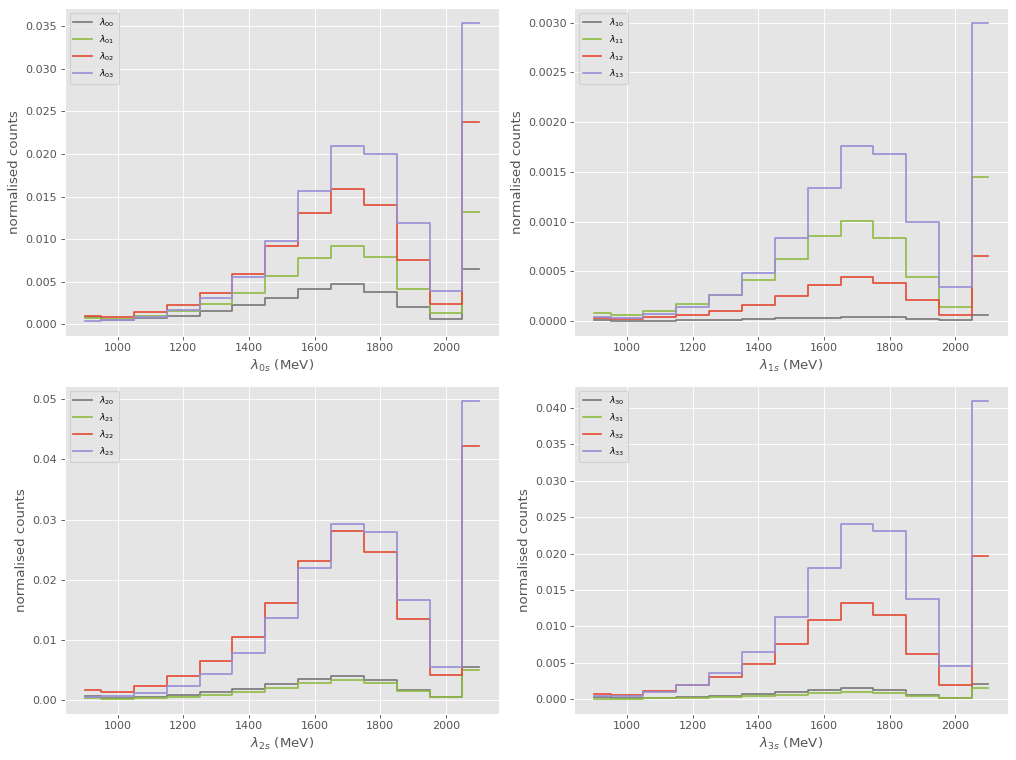

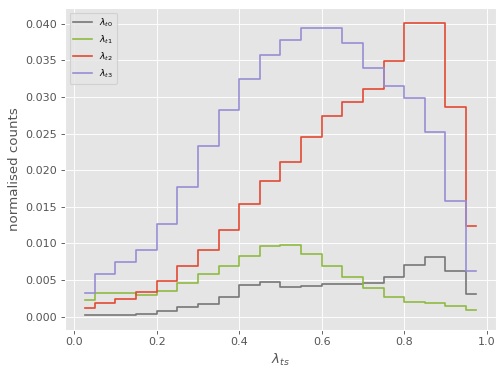

In [5]:
pdf = Plots.PlotBook("fit_templates.pdf", False)
cex_fit_studies.PlotTemplates(templates_energy, tempalates_mean_track_score, energy_slice, mean_track_score_bins, cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template))

# Validation test

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-521.69776191])
init_params=False
W VariableMetricBuilder No improvement in line search
poi_ind=[0, 1, 2, 3]
parameter=['mu_0', 'mu_1', 'mu_2', 'mu_3']
bestfit=array([1., 1., 1., 1.])
uncertainty=array([0.00181975, 0.00328798, 0.00185908, 0.00506844])
result=FitResults(bestfit=array([1., 1., 1., 1.]), uncertainty=array([0.00181975, 0.00328798, 0.00185908, 0.00506844]), labels=['mu_0', 'mu_1', 'mu_2', 'mu_3'], corr_mat=array([[ 1.        , -0.69455126, -0.58786259,  0.42471422],
       [-0.69455126,  1.        ,  0.46792624, -0.60370111],
       [-0.58786259,  0.46792624,  1.        , -0.84988607],
       [ 0.42471422, -0.60370111, -0.84988607,  1.        ]]), best_twice_nll=1043.395523810902, goodness_of_fit=-1, minos_uncertainty={})


counts_matrix=[[2240587, 678, 548378, 104803], [1105683, 152827, 172006, 41028], [1611495, 21146, 2182585, 290508],
[652796, 47699, 561378, 196734]]

total_count_actual, total_count, total_count_err=(9930331, 9930331.000000004, 9284.933490158333)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  1.00000  1.000000  1.000000  1.000000
error  0.00182  0.003288  0.001859  0.005068

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


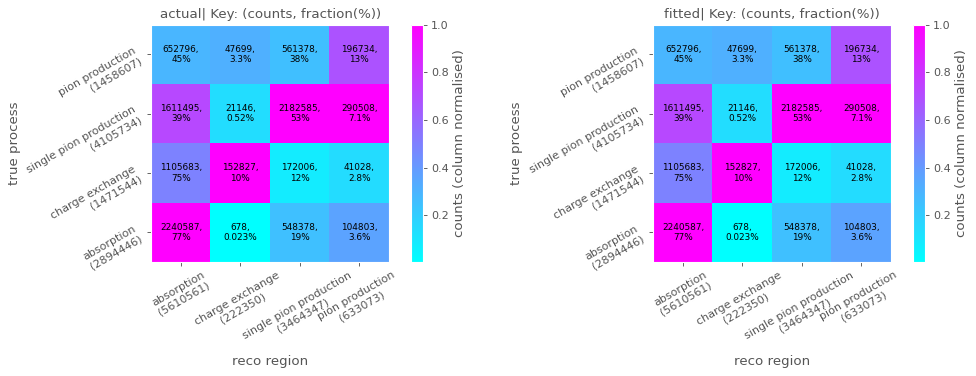

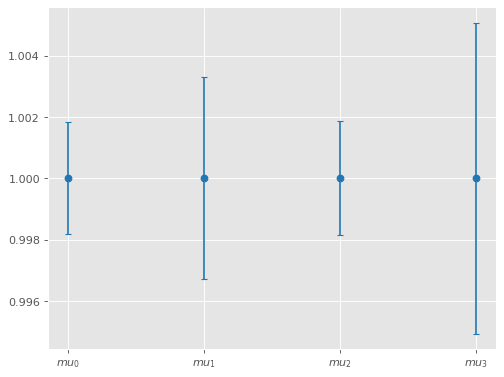

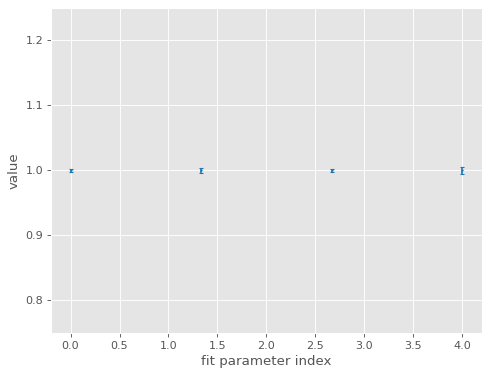

In [4]:
pdf = Plots.PlotBook("toy_validation_fit", False)
result = RegionFitToyStudy(toy_template, models["normal"], energy_slice, None, pdf = pdf)
pdf.close()

# ProtoDUNE MC Stats

In [39]:
toy_observed = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(PDSP = 2, p_init = 2000, seed = 1, events = 1E6, step = 2))))

Simulating |████████████████████████████████████████| 10/10 [100%] in 38.3s (0.26/s) 


'BeamSelectionEfficiency' executed in 0.0431s

'GenerateRecoRegions' executed in 1.3573s

'MeanTrackScore' executed in 3.0092s

'main' executed in 45.7803s

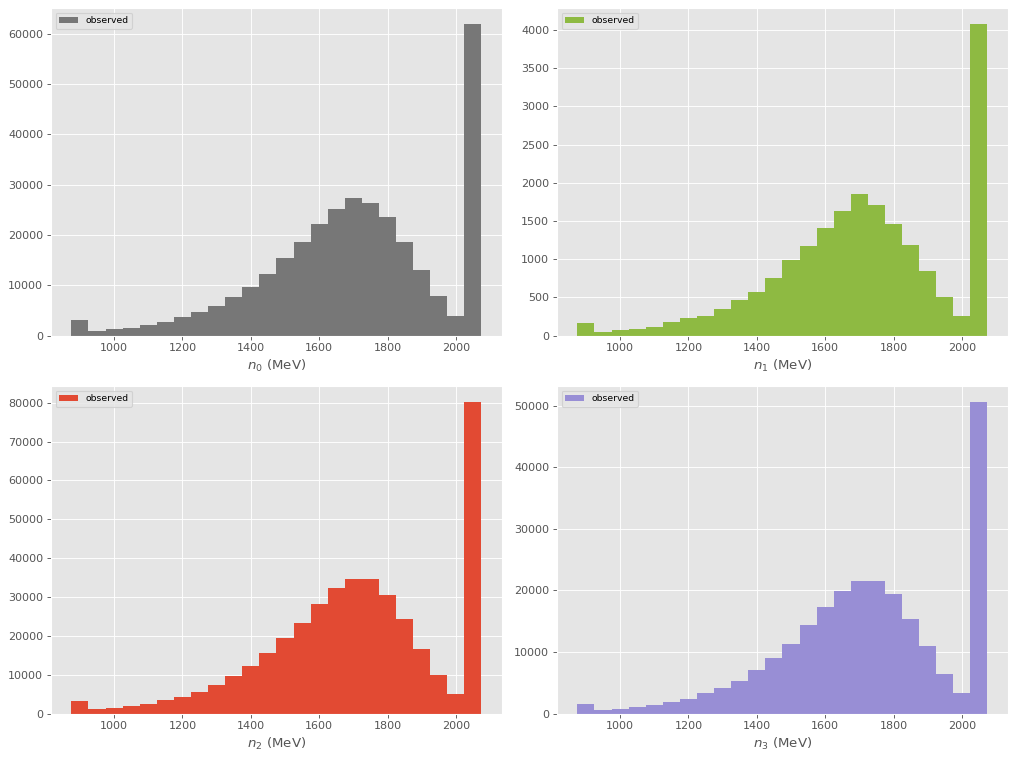

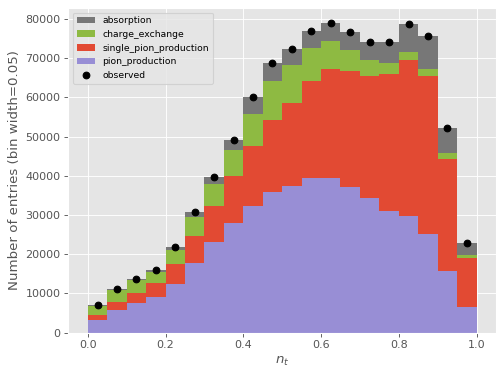

In [40]:
pdf = Plots.PlotBook("toy_observations.pdf", False)
tags = cross_section.Tags.ExclusiveProcessTags(toy_observed.truth_regions)

n_obs = cross_section.RegionFit.CreateObservedInputData(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_observed), energy_slice, mean_track_score_bins)
n_obs_energy = n_obs[:-1]
n_obs_mean_track_score = n_obs[-1]
for i, r in Plots.IterMultiPlot(toy_observed.reco_region_labels):
    Plots.Plot(energy_overflow, n_obs_energy[i], xlabel = f"$n_{{{i}}}$ (MeV)", marker = "o", color = tags[r].colour, linestyle = "-", label = "observed", style = "bar", newFigure = False)
pdf.Save()

Plots.PlotTagged(toy_observed.df.mean_track_score, tags, mean_track_score_bins, norm = False)
Plots.Plot(cross_section.bin_centers(mean_track_score_bins), n_obs_mean_track_score, xlabel = "$n_{t}$", marker = "o", color = "black", linestyle = "", label = "observed", newFigure = False)
pdf.Save()
pdf.close()

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697681.15439819])
init_params=False
poi_ind=[0, 1, 2, 3]
parameter=['mu_0', 'mu_1', 'mu_2', 'mu_3']
bestfit=array([0.10928021, 0.09558253, 0.09752618, 0.10144177])
uncertainty=array([0.00560573, 0.00205935, 0.00152917, 0.00082044])
result=FitResults(bestfit=array([0.10928021, 0.09558253, 0.09752618, 0.10144177]), uncertainty=array([0.00560573, 0.00205935, 0.00152917, 0.00082044]), labels=['mu_0', 'mu_1', 'mu_2', 'mu_3'], corr_mat=[[ 1.         -0.82067565 -0.8344876   0.62255273]
 [-0.82067565  1.          0.62136976 -0.56672765]
 [-0.8344876   0.62136976  1.         -0.90488129]
 [ 0.62255273 -0.56672765 -0.90488129  1.        ]], best_twice_nll=1068.6755750077696, goodness_of_fit=-1, minos_uncertainty={})


counts_matrix=[[31160, 319, 26970, 10337], [59042, 6351, 21894, 6694], [101252, 2864, 178234, 83852], [128870, 
10881, 181446, 149796]]

total_count_actual, total_count, total_count_err=(999962, 999962.2678605341, 4956.7059741171015)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  0.109280  0.095583  0.097526  0.101442
error  0.005606  0.002059  0.001529  0.000820

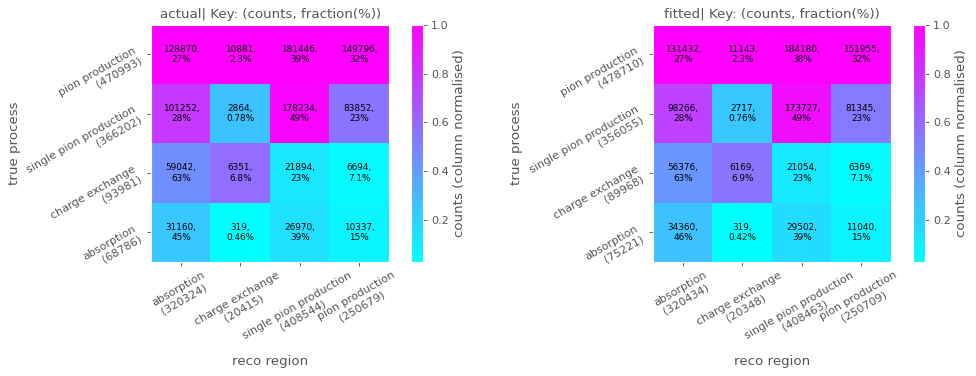

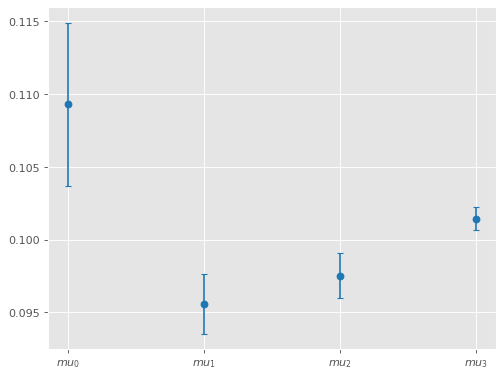

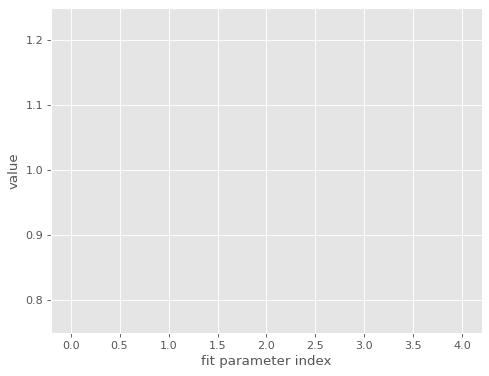

In [41]:
pdf_low_stats = Plots.PlotBook("toy_fit_low_stats.pdf", False)
result = RegionFitToyStudy(toy_observed, models["normal"], energy_slice, None, pdf = pdf_low_stats)
pdf_low_stats.close()

# Alternate correlation matrix

In [6]:
toy_alt = cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_fit_input.hdf5", smearing = True)
fractions = cross_section.ReadHDF5("work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5")

print(fractions)

fractions["pion_production"]["pion_production"] += 0.25
fractions["pion_production"]["single_pion_production"] -= 0.25

# fractions["charge_exchange"]["charge_exchange"] += 0.1
# fractions["charge_exchange"]["absorption"] -= 0.1


print(fractions)

regions = cex_toy_generator.GenerateRecoRegions(toy_template.df.exclusive_process, fractions, np.random.default_rng())
toy_alt._Toy__reco_regions = cross_section.Toy.GetRegion(regions, "reco_regions_")

absorption  charge_exchange  single_pion_production  \
absorption                0.756340         0.771416                0.440383   
charge_exchange           0.000238         0.095566                0.004684   
single_pion_production    0.196333         0.107476                0.489869   
pion_production           0.047089         0.025542                0.065065   

                        pion_production  
absorption                     0.469713  
charge_exchange                0.031233  
single_pion_production         0.369524  
pion_production                0.129529

absorption  charge_exchange  single_pion_production  \
absorption                0.756340         0.771416                0.440383   
charge_exchange           0.000238         0.095566                0.004684   
single_pion_production    0.196333         0.107476                0.489869   
pion_production           0.047089         0.025542                0.065065   

                        pion_production  
absorption                     0.469713  
charge_exchange                0.031233  
single_pion_production         0.119524  
pion_production                0.379529

'GenerateRecoRegions' executed in 15.3544s

In [9]:
cross_section.AnalysisInput.CreateAnalysisInputToy(toy_alt)

RegionFit.FitInput(regions={'absorption': array([False,  True,  True, ...,  True,  True,  True]), 'charge_exchange': array([False, False, False, ..., False, False, False]), 'single_pion_production': array([ True, False, False, ..., False, False, False]), 'pion_production': array([False, False, False, ..., False, False, False])}, outside_tpc=array([False, False, False, ..., False, False, False]), KE_int=array([790.78735067, 855.76283972, 846.89393684, ..., 792.53907374,
       808.40776848, 726.85612174]), KE_init=array([878.43655808, 827.73892447, 934.21780807, ..., 922.71766467,
       939.86234677, 802.99491719]), mean_track_score=array([0.7491085464398641, 0.631785005006679, 0.548571686403099, ...,
       0.794598364795846, 0.4354737227453884, 0.8886725692151805],
      dtype=object))

fit_input.regions={'absorption': array([False,  True,  True, ...,  True,  True,  True]), 'charge_exchange': array([False, False, False, ..., False, False, False]), 'single_pion_production': array([ True, False, False, ..., False, False, False]), 'pion_production': array([False, False, False, ..., False, False, False])}
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

counts_matrix=[[1826895, 570, 473524, 113995], [899530, 111561, 124753, 29515], [1423759, 15303, 1583047, 210654], 
[510551, 33788, 129983, 412788]]

total_count_actual, total_count, total_count_err=(7900216, 7898231.532061219, 11216.25780495737)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  1.391489  0.439683  0.451176  2.346546
error  0.002833  0.004277  0.003159  0.008264

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


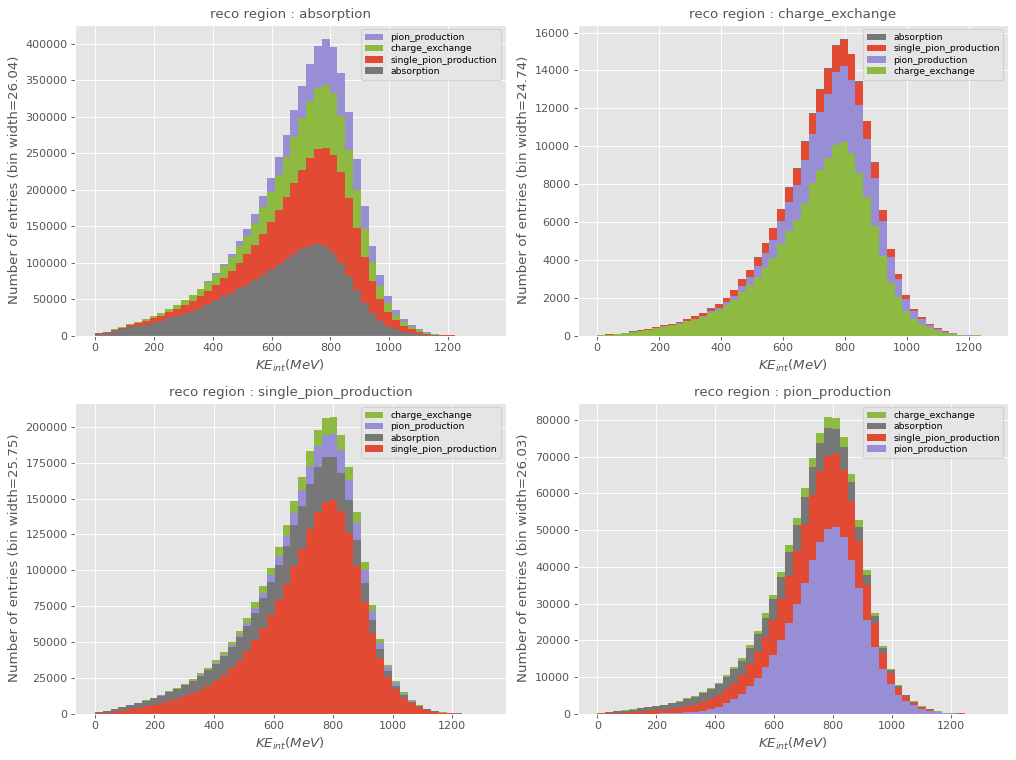

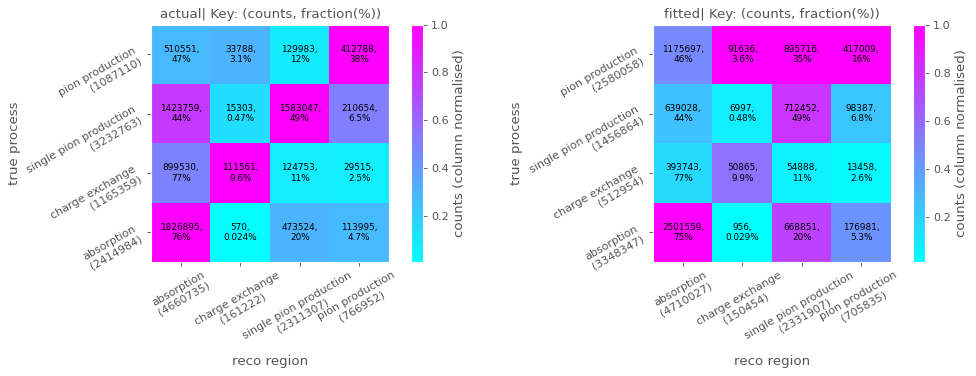

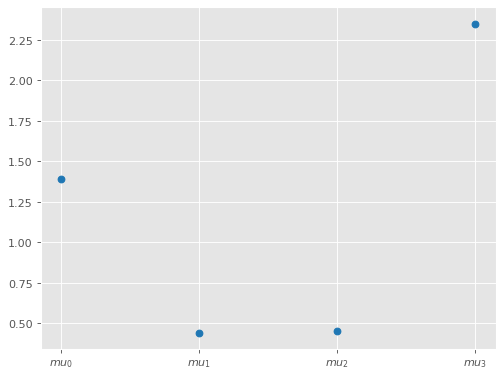

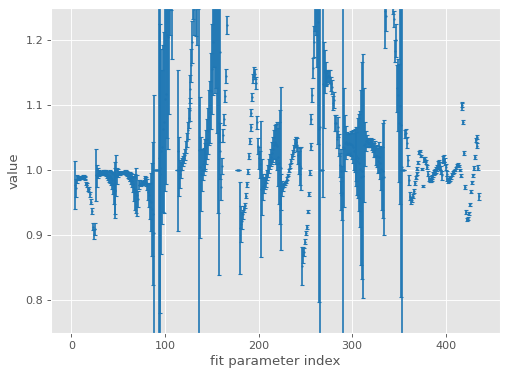

In [14]:
pdf = Plots.PlotBook("toy_vary_regions.pdf", False)
cross_section.Toy.PlotObservablesInRegions(toy_alt.df.KE_int_smeared, toy_alt.reco_regions, toy_alt.truth_regions, "$KE_{int} (MeV)$", stacked = True, histtype = "stepfilled")
result = RegionFitToyStudy(toy_alt, models["normal"], energy_slice, mean_track_score_bins, pdf = pdf)
pdf.close()

# Modified exclusive process rates

In [5]:
def PlotObservedToy(scales : dict[int], config_args : dict):
    toy_alt_pdf = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(scale_factors = scales, **config_args))))
    cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")
    cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)", stacked = True, histtype = "stepfilled")
    Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins)
    Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins, histtype = "step", reverse_sort = True)

In [6]:
toy_data_config = {"PDSP" : 2, "p_init" : 2000, "seed" : 1, "events" : 43035}

## original PDFs

Simulating |████████████████████████████████████████| 1/1 [100%] in 5.0s (0.20/s) 


'BeamSelectionEfficiency' executed in 0.0088s

'GenerateRecoRegions' executed in 0.0794s

'MeanTrackScore' executed in 0.2762s

'main' executed in 5.5610s

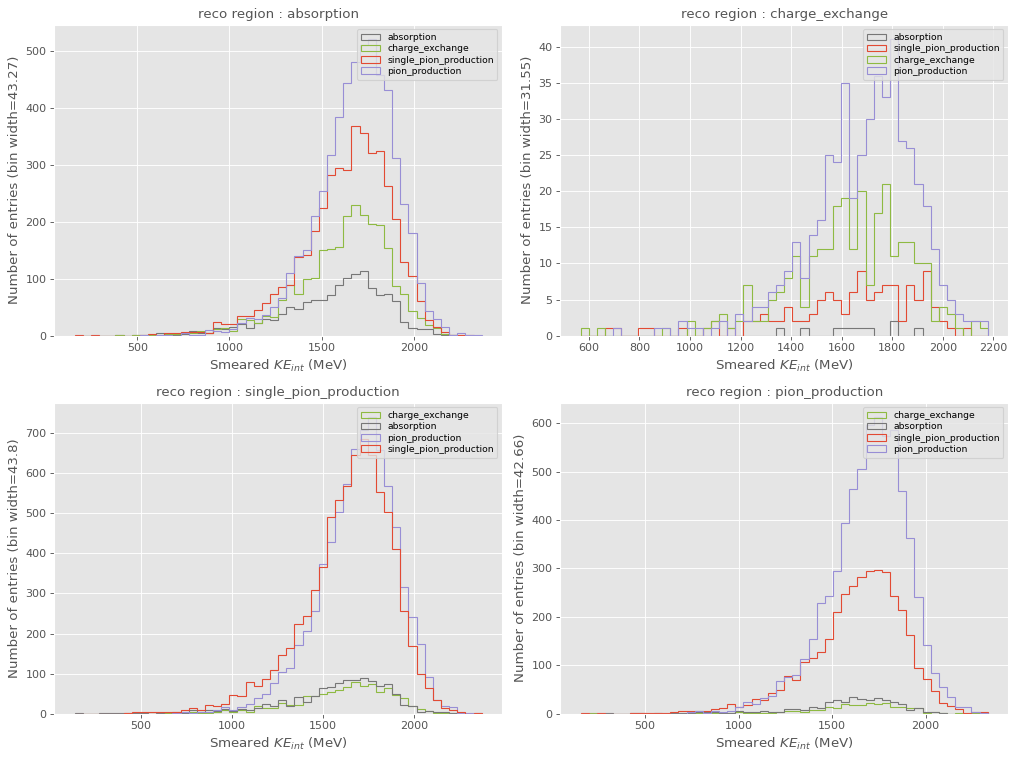

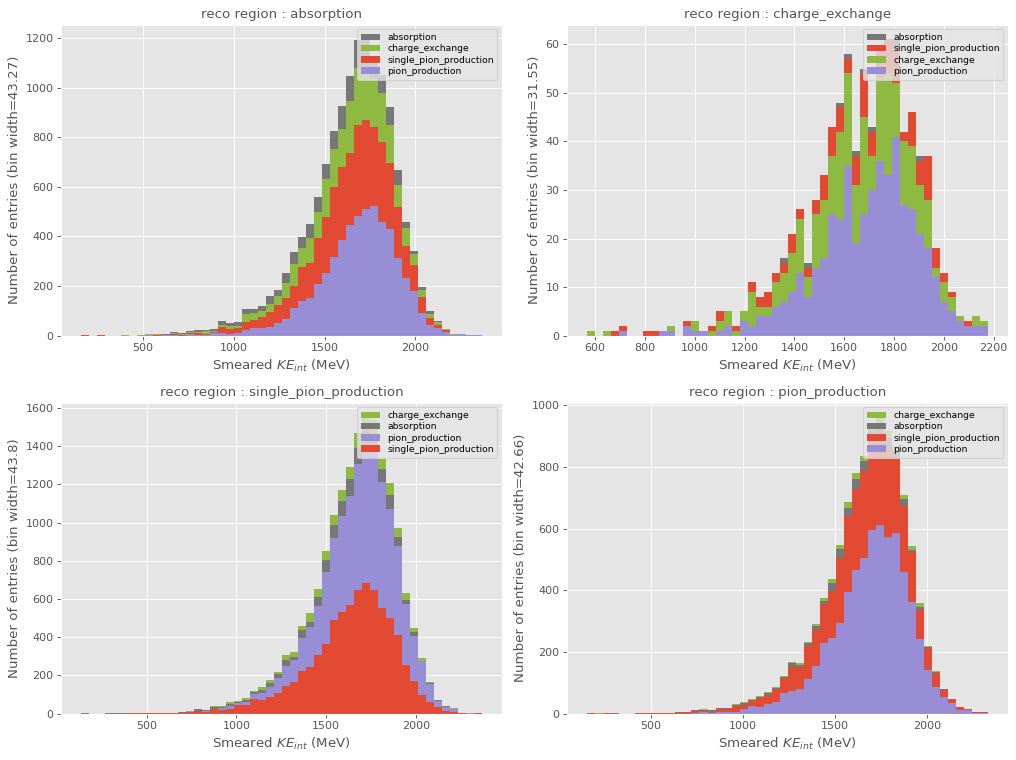

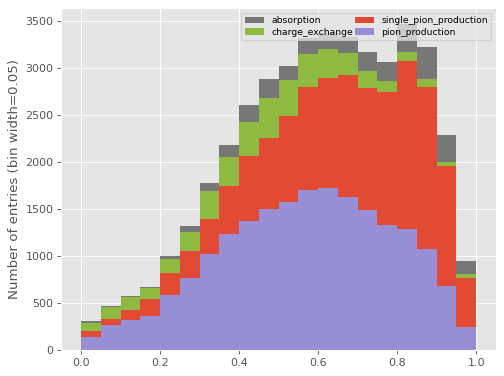

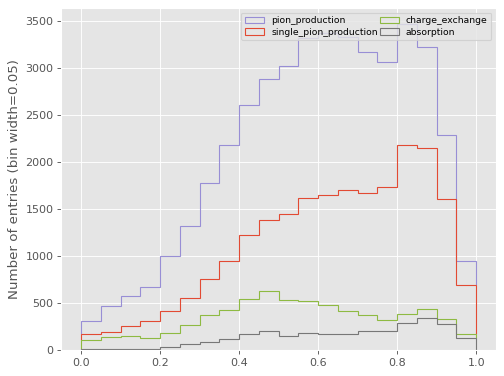

In [22]:
PlotObservedToy(None, toy_data_config)

## modified PDFs

Simulating |████████████████████████████████████████| 1/1 [100%] in 4.1s (0.24/s) 


'BeamSelectionEfficiency' executed in 0.0056s

'GenerateRecoRegions' executed in 0.0790s

'MeanTrackScore' executed in 0.3043s

'main' executed in 4.7102s

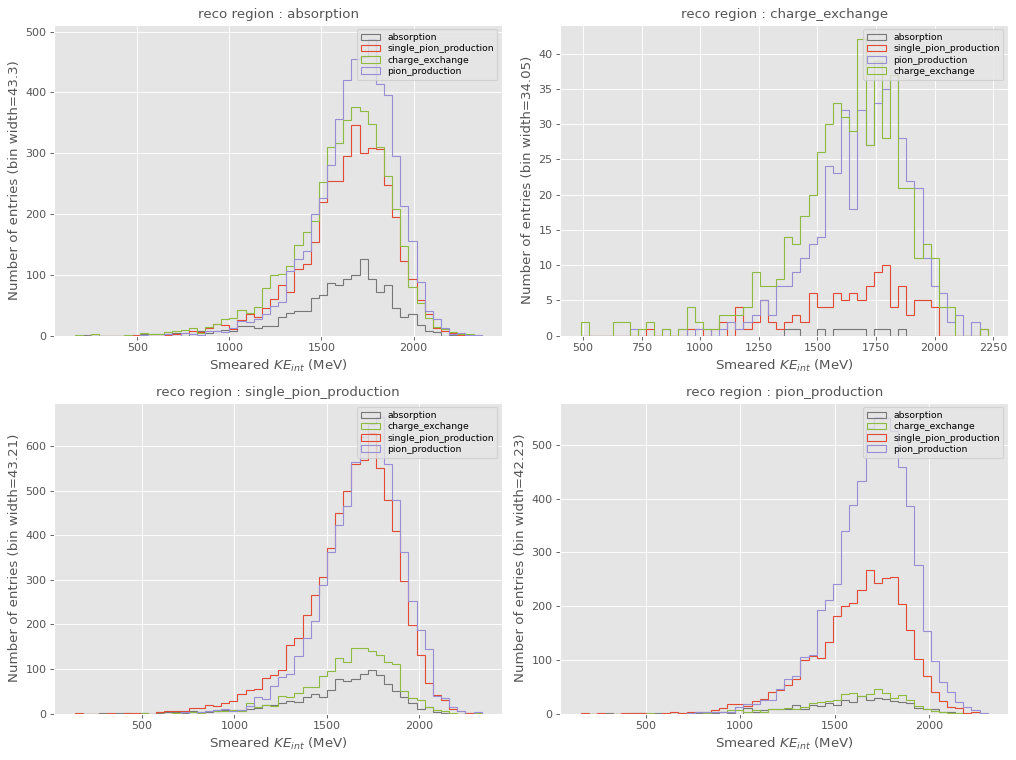

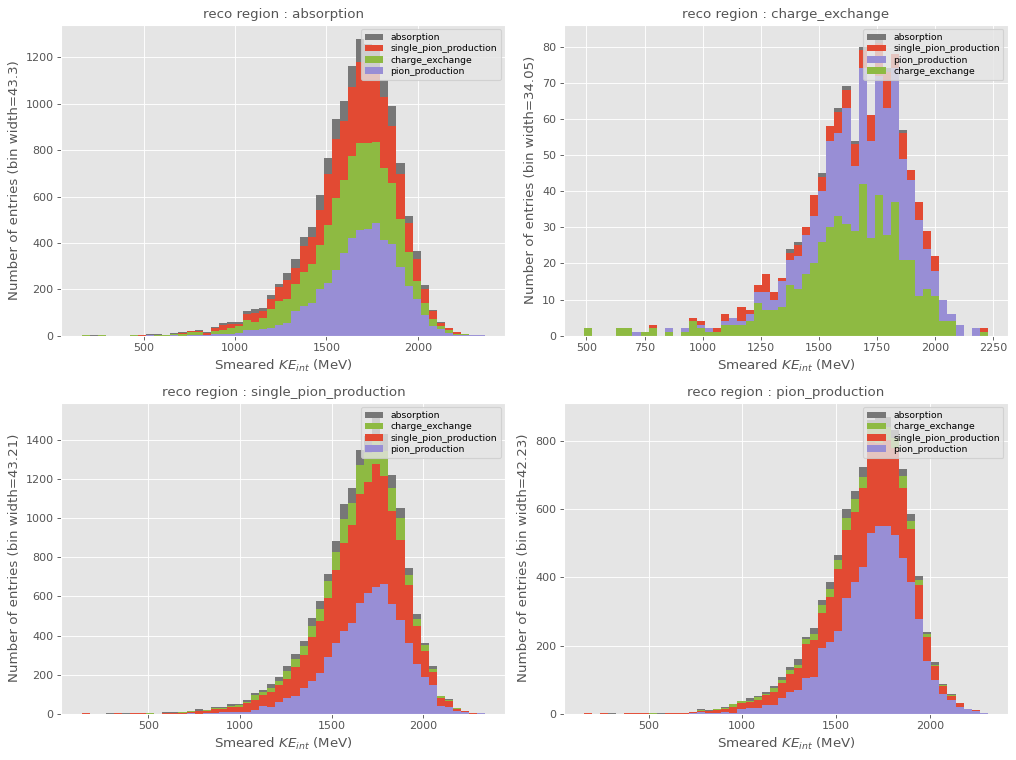

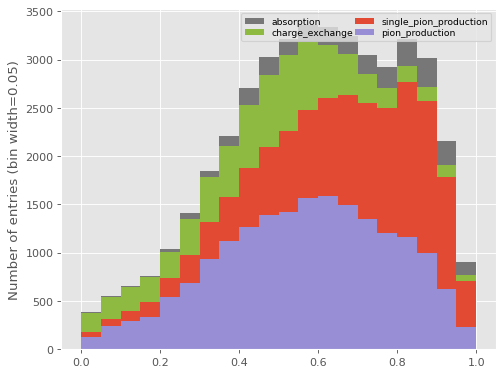

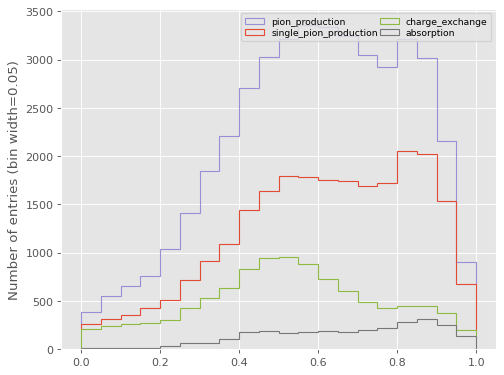

In [25]:
scales = {
    'absorption': 1,
    'quasielastic': 1,
    'charge_exchange': 2,
    'double_charge_exchange': 1,
    'pion_production': 1
    }
PlotObservedToy(scales, toy_data_config)

## Compare shapes

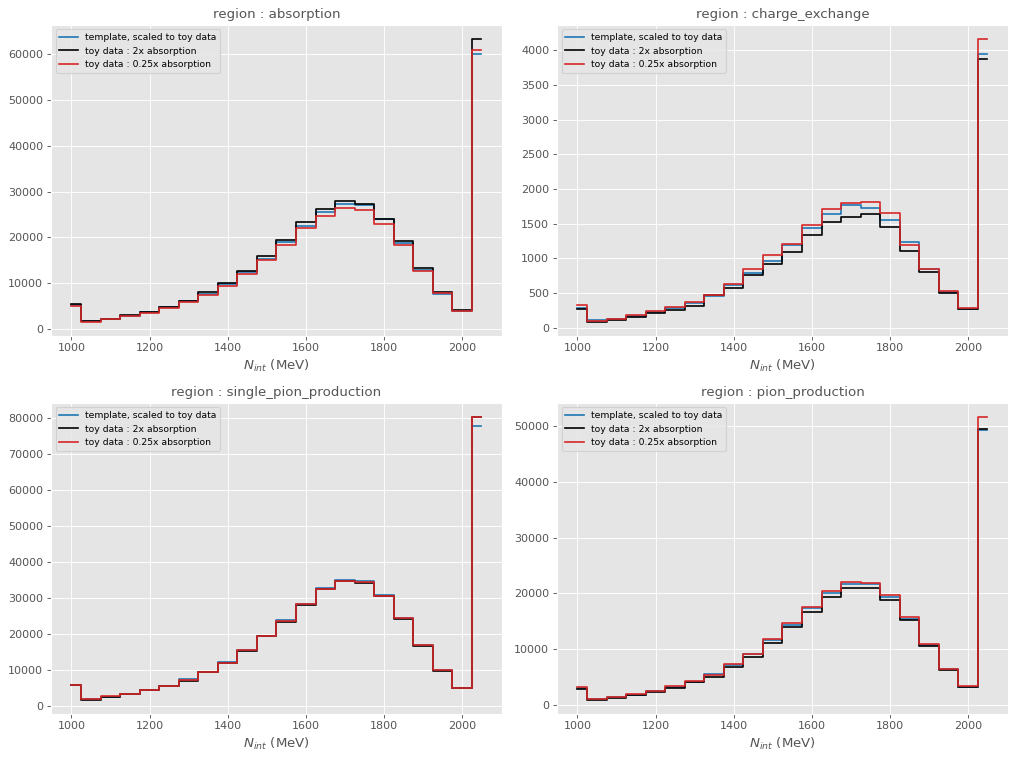

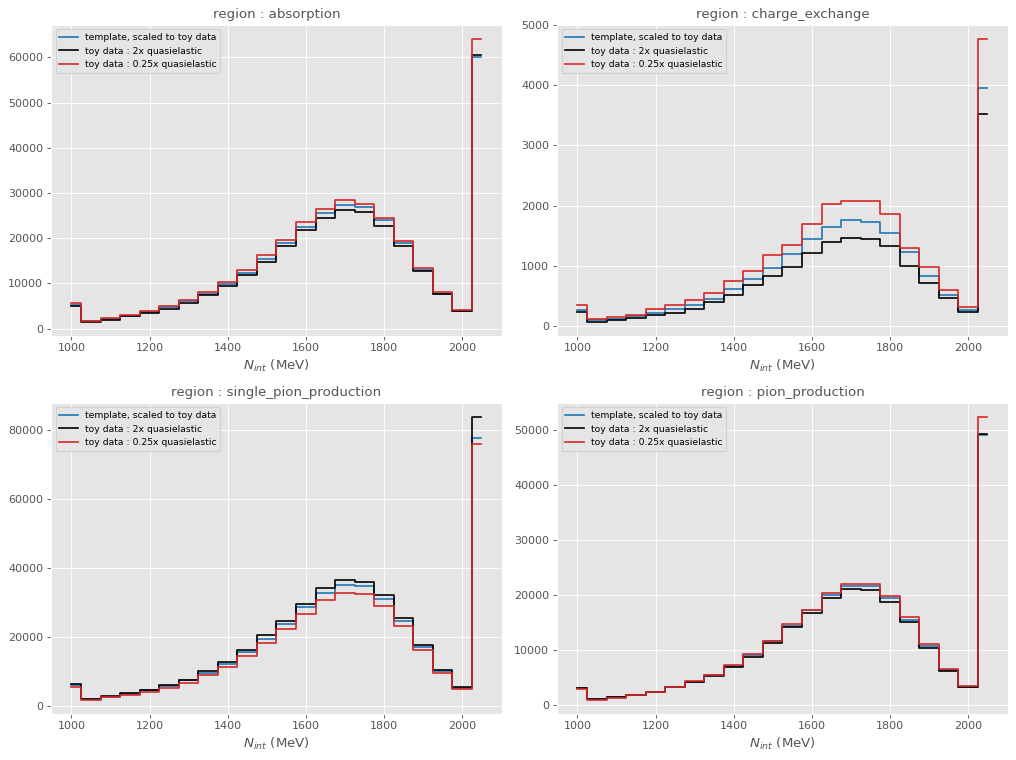

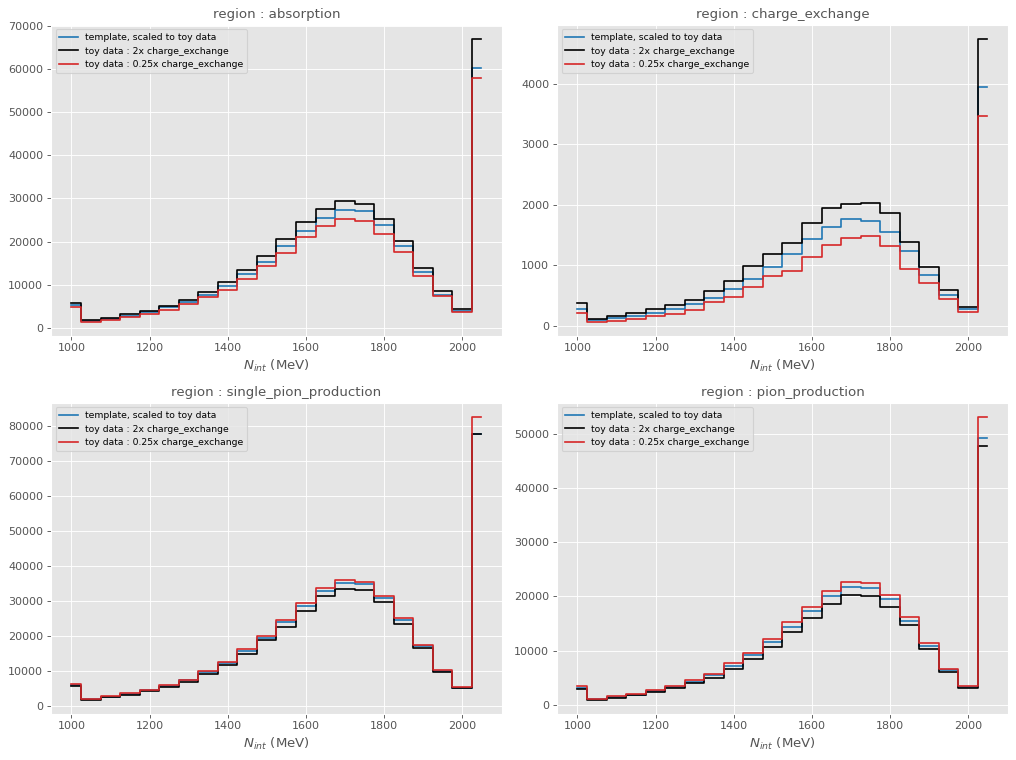

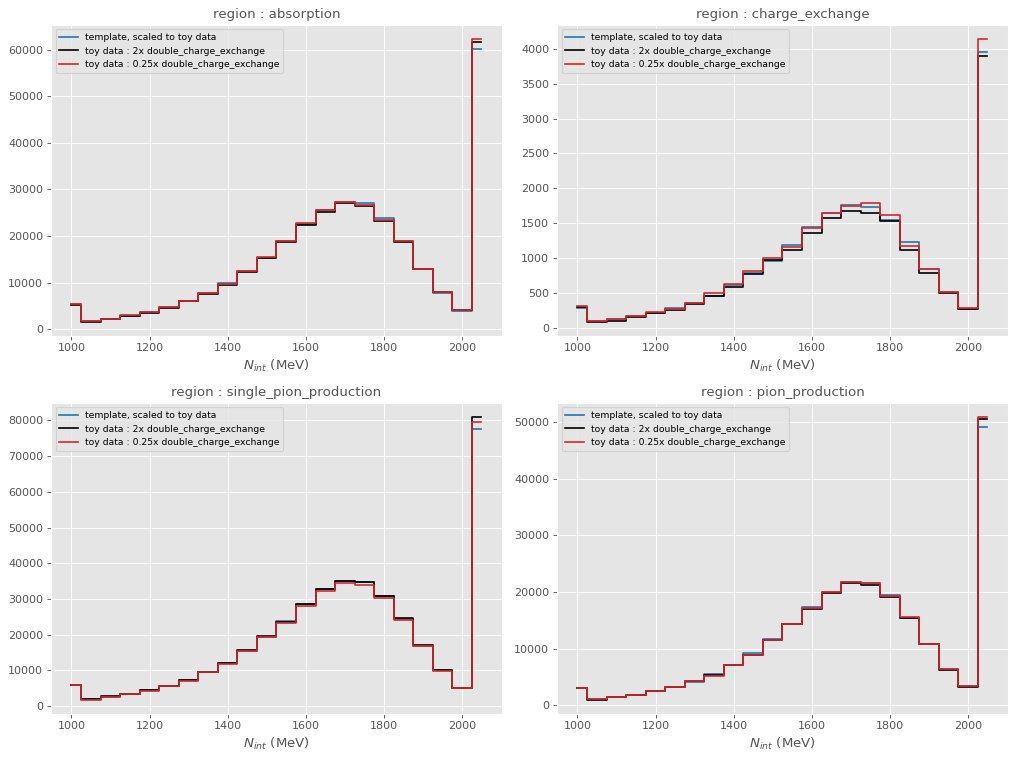

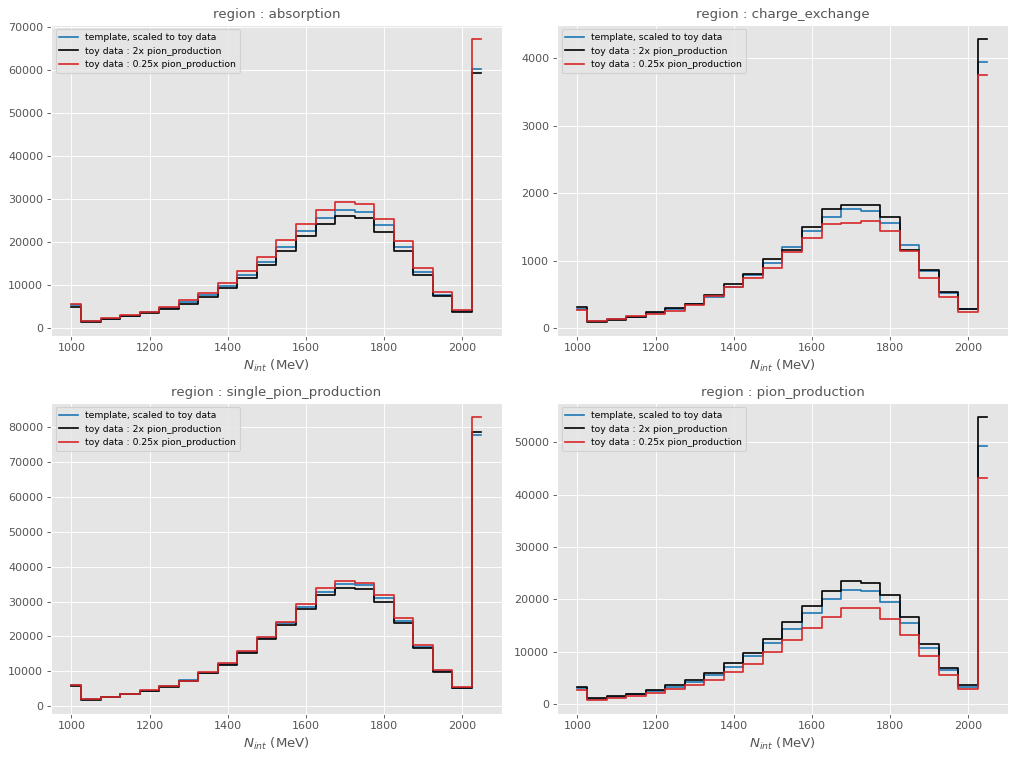

In [7]:
def CompareShapes(events : int, toy_config : dict, mean_track_score_bins : np.array = None, book : Plots.PlotBook = Plots.PlotBook.null):
    scale = events / len(toy_template.df)
    scales = {'absorption': 1, 'quasielastic': 1, 'charge_exchange': 1, 'double_charge_exchange': 1, 'pion_production': 1}

    n_int_temp = {r : toy_template.NInteract(energy_slice, toy_template.reco_regions[r]) for r in toy_template.reco_region_labels}

    n_channels = len(toy_template.reco_region_labels) + int(mean_track_score_bins is not None)

    tags = cross_section.Tags.ExclusiveProcessTags(toy_template.truth_regions)

    colors = ["k", "C6"]

    for p in scales:
        scales_low = dict(scales)
        scales_high = dict(scales)

        scales_low[p] = 0.25
        scales_high[p] = 2
        toy_config["events"] = events
        toys = {k : cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(scale_factors = s, **toy_config)))) for k, s in zip([f"toy data : 2x {p}", f"toy data : 0.25x {p}"], [scales_high, scales_low])}
        clear_output()

        multiplot = Plots.MultiPlot(n_channels)
        for r in toy_template.reco_region_labels:
            next(multiplot)
            Plots.Plot(energy_overflow, scale * n_int_temp[r], newFigure = False, style = "step", title = f"region : {r}", label = "template, scaled to toy data", xlabel = "$N_{int}$ (MeV)")
            for i, (k, v) in enumerate(toys.items()):
                n_int = v.NInteract(energy_slice, v.reco_regions[r])
                Plots.Plot(energy_overflow, n_int, newFigure = False, style = "step", label = k, color = colors[i])
        
        if mean_track_score_bins is not None:
            next(multiplot)
            Plots.PlotTagged(toy_template.df.mean_track_score.values, tags = tags, bins = mean_track_score_bins, newFigure = False, x_label = "mean track score", data_weights = scale * np.ones(len(toy_template.df)))
            for i, (k, v) in enumerate(toys.items()):
                mean_track_score = np.histogram(v.df.mean_track_score, bins = mean_track_score_bins)[0]
                Plots.Plot(cross_section.bin_centers(mean_track_score_bins), mean_track_score, newFigure = False, style = "step", label = k, color = colors[i])

        book.Save()

with Plots.PlotBook("shape_comparison.pdf", False) as book:
    CompareShapes(1E6, toy_data_config, None, book)

## Fit for different rates

In [9]:
cex_fit_studies.NormalisationTest(
    directory = "test/region_fit_cross_checks_1GeV/normalisation_test_track_score/",
    data_config = {"PDSP" : 1, "p_init" : 1000, "seed" : 1, "events" : 1E4, "step" : 2},
    model = models["track_score"],
    toy_template = toy_template,
    mean_track_score_bins = mean_track_score_bins)

pion_production

pdf test/region_fit_cross_checks_1GeV/normalisation_test_track_score/fit_results_pip.pdf has been opened
pdf test/region_fit_cross_checks_1GeV/normalisation_test_track_score/fit_results_pip.pdf has been closed


In [ ]:
directory = "test/region_fit_cross_checks_1GeV/normalisation_test/"
results_files = [i for i in cross_section.os.listdir(directory) if "dill" in i]

target_map = {
    "_abs" : 'absorption',
    "_quasi" : 'quasielastic',
    "_cex" : 'charge_exchange',
    "_dcex" : 'double_charge_exchange',
    "_pip" : 'pion_production'
}

for f in results_files:
    fit_result = cross_section.LoadObject(directory+f)
    target = [target_map[k] for k in target_map if k in f][0]
    with Plots.PlotBook(directory+f.split(".")[0]+".pdf", False) as pdf:
        cex_fit_studies.PlotCrossCheckResults(f"{target} normalisation", models["normal"], toy_template, fit_result["results"], fit_result["true_counts"], energy_overflow, pdf)
    Plots.plt.close("all")

In [ ]:
scales = {
    'absorption': 1,
    'quasielastic': 1,
    'charge_exchange': 1,
    'double_charge_exchange': 1,
    'pion_production': 1
    }
toy_alt_pdf = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(scale_factors = scales, PDSP = 1, p_init = 1000, events = 1E6, seed = 1)))))
obs = cross_section.RegionFit.GenerateObservations(toy_alt_pdf, energy_slice, mean_track_score_bins, models["normal"], False)
fit_result = cross_section.RegionFit.Fit(obs, models["normal"], None, None, False)

postfit_pred = cross_section.cabinetry.model_utils.prediction(models["normal"], fit_results = fit_result)


pdf test/region_fit_cross_checks_1GeV/toy_obs_nominal.pdf has been opened
pdf test/region_fit_cross_checks_1GeV/toy_obs_nominal.pdf has been closed


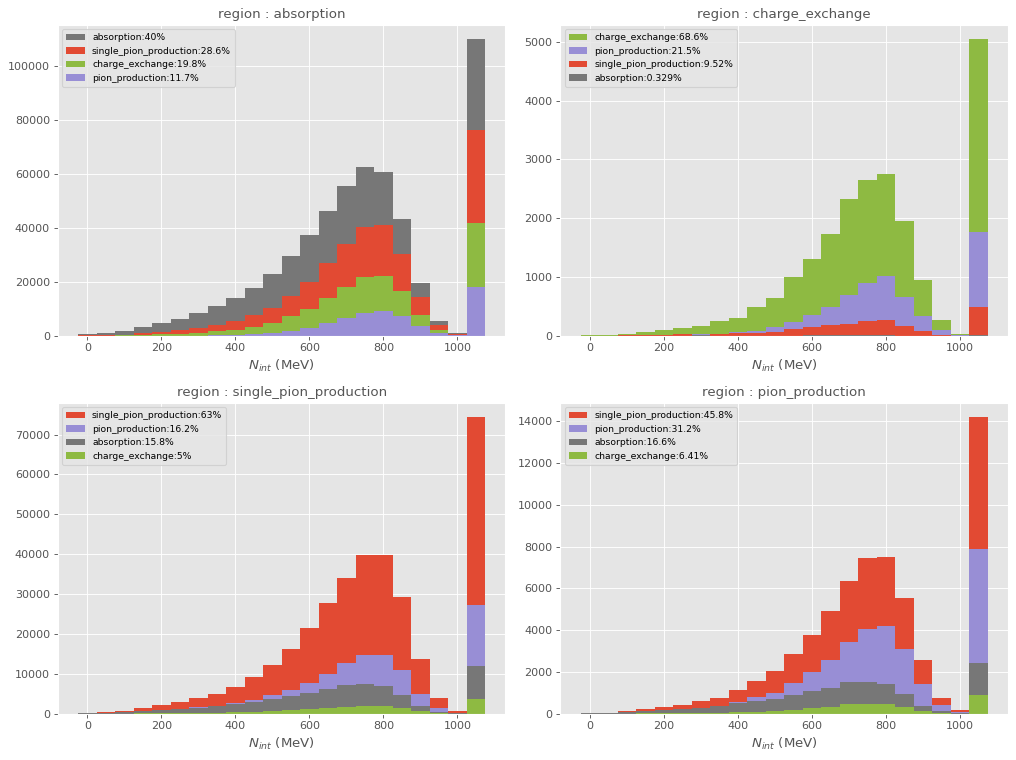

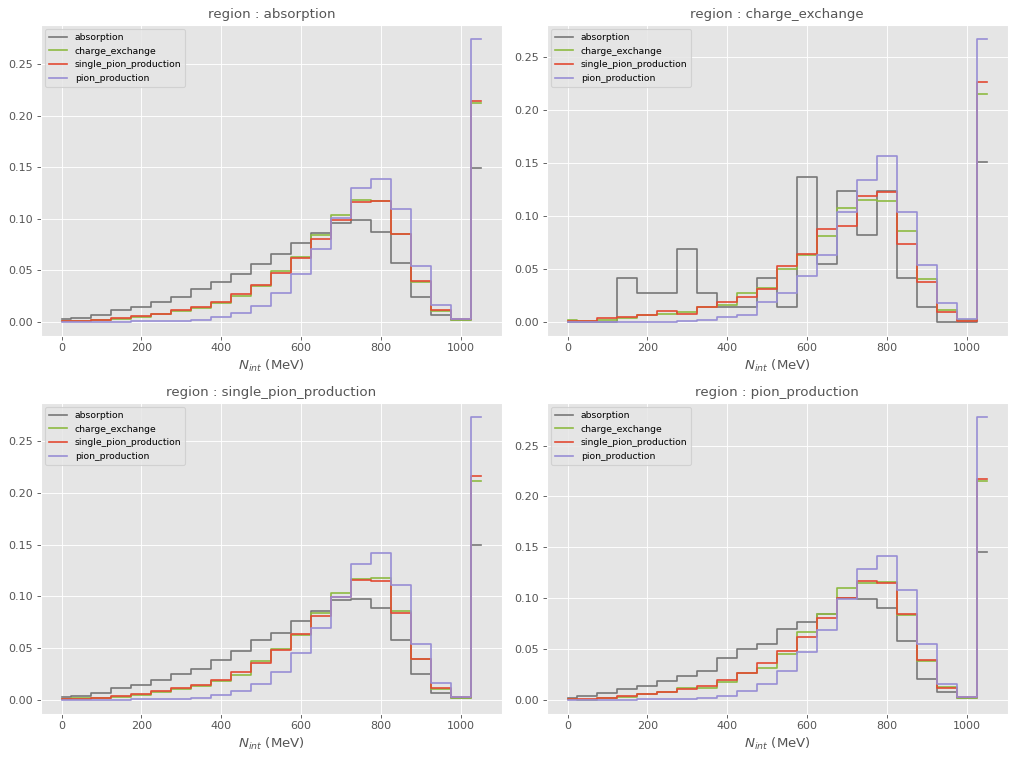

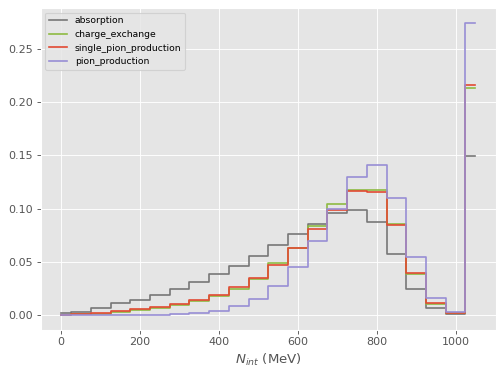

In [15]:
tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.exclusive_process)

with Plots.PlotBook("test/region_fit_cross_checks_1GeV/toy_obs_nominal.pdf", True) as pdf:
    for i, c in Plots.IterMultiPlot(toy_alt_pdf.regions):
        hists = {s : toy_alt_pdf.NInteract(energy_slice, toy_alt_pdf.exclusive_process[s], toy_alt_pdf.regions[c]) for s in toy_alt_pdf.exclusive_process}

        sorted_proc = [list(toy_alt_pdf.exclusive_process.keys())[j] for j in np.argsort([sum(h) for h in hists.values()])]

        total = np.zeros_like(energy_overflow)
        stacked_hists = {}
        for s in sorted_proc:
            total = total + hists[s]
            stacked_hists[s] = total

        for s in reversed(stacked_hists):
            purity = sum(toy_alt_pdf.exclusive_process[s] & toy_alt_pdf.regions[c]) / sum(toy_alt_pdf.regions[c])
            Plots.Plot(energy_overflow, stacked_hists[s], newFigure = False, label = s + f":{100*purity:.3g}%", color = tags[s].colour, style = "bar", xlabel = "$N_{int}$ (MeV)", title = f"region : {c}")
    pdf.Save()

    for i, c in Plots.IterMultiPlot(toy_alt_pdf.regions):
        hists = {s : toy_alt_pdf.NInteract(energy_slice, toy_alt_pdf.exclusive_process[s], toy_alt_pdf.regions[c]) for s in toy_alt_pdf.exclusive_process}
        for s in hists:
            Plots.Plot(energy_overflow, hists[s] / sum(hists[s]), newFigure = False, label = s, color = tags[s].colour, style = "step", xlabel = "$N_{int}$ (MeV)", title = f"region : {c}")
    pdf.Save()


    plt.figure()
    for s in toy_alt_pdf.exclusive_process:
        hists = toy_alt_pdf.NInteract(energy_slice, toy_alt_pdf.exclusive_process[s])
        Plots.Plot(energy_overflow, hists / sum(hists), newFigure = False, label = s, color = tags[s].colour, style = "step", xlabel = "$N_{int}$ (MeV)")
    pdf.Save()

In [27]:
results = cross_section.LoadObject("test/new_shape_test/normalisation_test_normal/fit_results_abs.dill")
pull_results = cross_section.ReadHDF5("test/region_fit_studies_2GeV/pull_test_normal/pull_results.hdf5")


bias_counts=[array([237.52413556,   0.32671821,   3.03847931,  20.6485906 ,
        74.0016736 , 142.18776313, 168.48857869, 151.95663748,
       115.10282387,  82.03894146,  57.11034236,  38.42206099,
        24.34050633,  18.32889134,  37.4745782 ]), array([-249.75309436,   -0.32548693,   -3.90584313,  
-23.49318146,
        -81.3252338 , -151.0026854 , -175.07709352, -149.96810195,
       -108.56151493,  -72.30459609,  -45.18456029,  -30.92125813,
        -17.94827916,  -11.578035  ,  -16.30921999]), array([-361.59729055,   -0.59381036,   -5.86751078,  
-36.12277163,
       -117.50385892, -216.14697192, -248.39544237, -203.29492247,
       -143.97202151,  -94.25389934,  -59.05713968,  -36.24319471,
        -21.86301789,  -12.92264229,  -16.47719943]), array([99.50510775,  0.16920163,  1.97146701, 11.28904117, 
34.03555953,
       56.99798223, 60.33990591, 45.07883724, 28.39448422, 16.21043531,
        9.04577968,  4.73841138,  2.57783666,  1.33753509,  1.26556698])]

bias_counts=[array([369.87768069,   0.58809277,   5.03146037,  32.70449239,
       115.33152662, 225.01082828, 267.54953866, 240.26856849,
       182.7988361 , 128.66162941,  88.90002378,  59.46271344,
        37.24587545,  26.85623651,  53.74514484]), array([-245.92862296,   -0.30223786,   -4.05696206,  
-23.79541932,
        -79.2211933 , -147.77106519, -171.60135811, -146.39937028,
       -106.4458499 ,  -70.51441798,  -44.3475939 ,  -29.93317282,
        -17.09968824,  -10.99680834,  -15.34438374]), array([-355.58028905,   -0.58550532,   -5.69310494,  
-35.45836842,
       -115.88437611, -212.2436031 , -243.41657087, -198.78528573,
       -139.90255189,  -91.60043905,  -56.88537171,  -34.86871058,
        -21.11141177,  -12.35789957,  -15.26466358]), array([97.76485746,  0.16613916,  1.94696722, 11.10912088, 
33.50422046,
       55.98966299, 59.16544751, 44.07587732, 27.69777161, 15.72503334,
        8.75637598,  4.56385042,  2.46988449,  1.28011372,  1.17139593])]

bias_counts=[array([410.75012823,   0.81679551,   5.81558406,  36.59243904,
       130.3932359 , 250.95225381, 299.04517369, 267.84358505,
       206.25720327, 143.78868234,  98.24416446,  66.5524985 ,
        41.78725851,  29.79670036,  58.80927703]), array([-244.92891311,   -0.29061333,   -4.1034602 ,  
-23.66754946,
        -78.32610425, -146.94572333, -170.81088986, -145.73677189,
       -105.70187978,  -69.80532146,  -43.95235978,  -29.71230669,
        -17.04156557,  -10.93868568,  -15.04214587]), array([-353.81131552,   -0.56474272,   -5.61420706,  
-35.25904746,
       -115.18260023, -211.09750758, -241.86352838, -197.21978568,
       -138.56544044,  -90.69934221,  -56.30817143,  -34.32888298,
        -20.73768496,  -12.09629081,  -14.84110654]), array([97.19906557,  0.16537354,  1.94007666, 11.06318379, 
33.33961253,
       55.64743163, 58.76579478, 43.76197384, 27.44358635, 15.58339396,
        8.66986112,  4.51178838,  2.43619729,  1.26327012,  1.15072424])]

bias_counts=[array([455.18380421,   0.49007731,   6.56703593,  43.29016226,
       142.08974767, 272.02557808, 330.24676234, 293.42562056,
       222.29906717, 159.14443801, 107.26158694,  71.68197433,
        47.24345255,  31.65899413,  64.75554837]), array([-240.27909986,   -0.31386239,   -3.17349755,  -23.0514492
,
        -76.83816401, -145.05092443, -171.82222424, -141.55193996,
       -103.46996942,  -71.35138437,  -44.71957896,  -28.59635151,
        -17.21593357,  -10.99680834,  -14.05406056]), array([-352.59877968,   -0.60626792,   -5.88827338,  
-34.9351509 ,
       -115.21166787, -210.69056062, -239.5837949 , -197.29868356,
       -138.44916988,  -88.97189388,  -55.41122711,  -34.37040818,
        -20.12726452,  -11.95925765,  -14.55873518]), array([96.68763257,  0.16384231,  1.93318609, 11.00652803, 
33.15816101,
       55.35343422, 58.38834498, 43.42357057, 27.2361038 , 15.44022335,
        8.57339322,  4.45742948,  2.40940065,  1.24106719,  1.12852131])]

bias_counts=[array([498.50663829,   0.98015462,   7.25314417,  44.69505054,
       156.69405146, 302.90044852, 361.80774101, 318.7462815 ,
       245.75743434, 171.82110439, 117.38985131,  79.55588309,
        50.44529096,  35.4162535 ,  68.67616684]), array([-242.51101022,   -0.2789888 ,   -4.20808099,  
-23.49318146,
        -77.23339814, -145.86464175, -168.63710216, -143.70247859,
       -104.6556718 ,  -68.53824735,  -43.67337098,  -28.78234404,
        -17.11131277,  -10.69457048,  -14.26330215]), array([-349.24769602,   -0.5605902 ,   -5.48963146,  
-34.84794798,
       -114.21506306, -208.39006453, -238.72007073, -195.00649251,
       -136.31062207,  -89.09231696,  -54.9959751 ,  -33.60219198,
        -19.90302844,  -11.66027621,  -14.16009326]), array([96.14327799,  0.16307669,  1.92246744, 10.96059094, 
32.97364701,
       55.0004842 , 58.01778575, 43.11119832, 27.00259024, 15.30624015,
        8.48151903,  4.40230497,  2.38260401,  1.22805168,  1.09636534])]

bias_counts=[array([538.66030577,   1.07817008,   7.84123694,  48.77902811,
       168.81529689, 327.76370398, 392.45390871, 344.29564519,
       264.83777756, 186.85014185, 128.1715521 ,  86.38429359,
        54.10453487,  37.93198368,  72.85815988]), array([-240.90682465,   -0.30223786,   -4.1034602 ,  
-23.49318146,
        -76.55917521, -144.8300583 , -167.69551498, -142.47027808,
       -104.01632247,  -68.38712842,  -43.23163872,  -28.34061178,
        -17.16943544,  -10.61319875,  -13.98431336]), array([-347.65728086,   -0.5398276 ,   -5.52700414,  
-34.55311906,
       -113.88701398, -207.33947696, -237.19609589, -193.88531211,
       -135.24342443,  -88.05418696,  -54.2900467 ,  -33.21600762,
        -19.55836928,  -11.44019265,  -13.84865426]), array([95.60122027,  0.16307669,  1.90868631, 10.91924755, 
32.79449234,
       54.67969016, 57.6426328 , 42.80035731, 26.79434207, 15.15541336,
        8.3881136 ,  4.34258674,  2.35657299,  1.21503617,  1.07416241])]

bias_counts=[array([662.81322394,   1.20885736,   9.31146886,  59.85477529,
       206.25720327, 403.75835863, 485.69928462, 421.23778263,
       321.68674535, 228.67007218, 154.27633674, 102.45882931,
        65.70303117,  45.31581513,  85.24077987]), array([-236.69874365,   -0.29061333,   -3.95234127,  
-23.31881346,
        -75.41997097, -142.73764234, -166.06808034, -140.01750159,
       -101.12181372,  -67.13167884,  -42.49929313,  -27.17815847,
        -16.39059172,  -10.25283822,  -12.64749205]), array([-341.88943055,   -0.5398276 ,   -5.51039406,  
-34.07973178,
       -112.18448078, -203.33644767, -231.88087026, -189.82830005,
       -132.32420286,  -85.30521871,  -52.70793657,  -32.37719857,
        -18.81091568,  -10.9335852 ,  -13.03060781]), array([94.03246846,  0.16077983,  1.887249  , 10.75846772, 
32.30602789,
       53.77472938, 56.54473622, 41.90688081, 26.19103489, 14.76494805,
        8.11631912,  4.19711927,  2.27388622,  1.15914604,  1.02286599])]

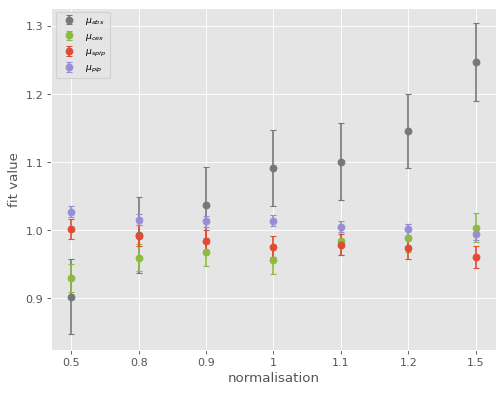

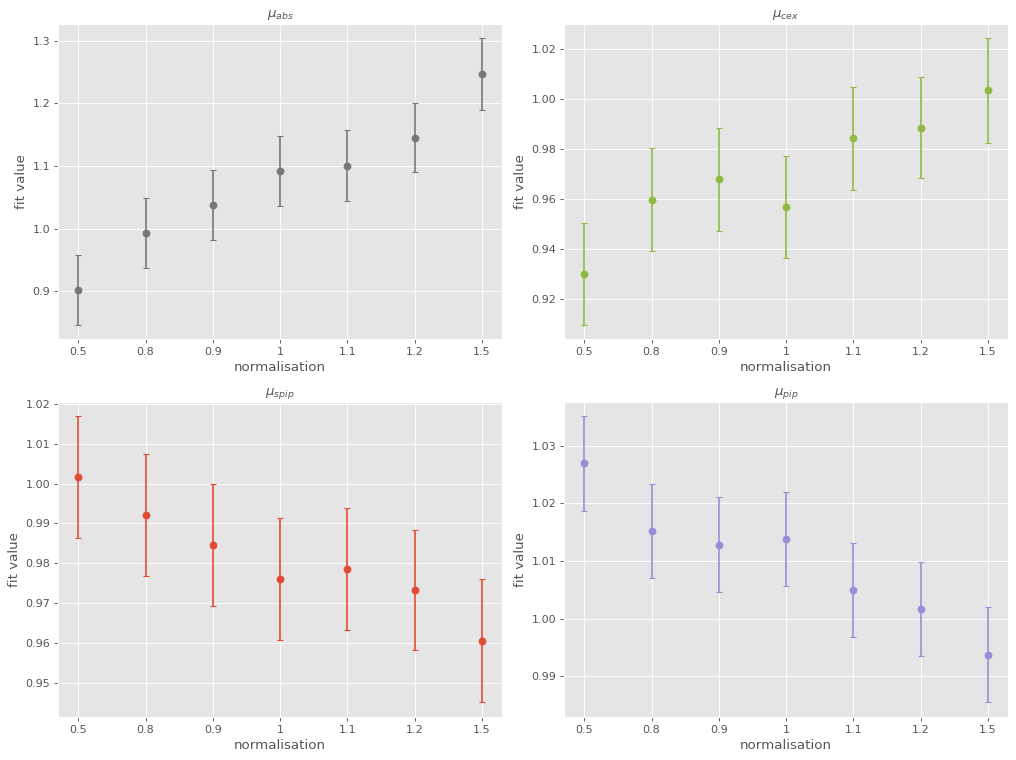

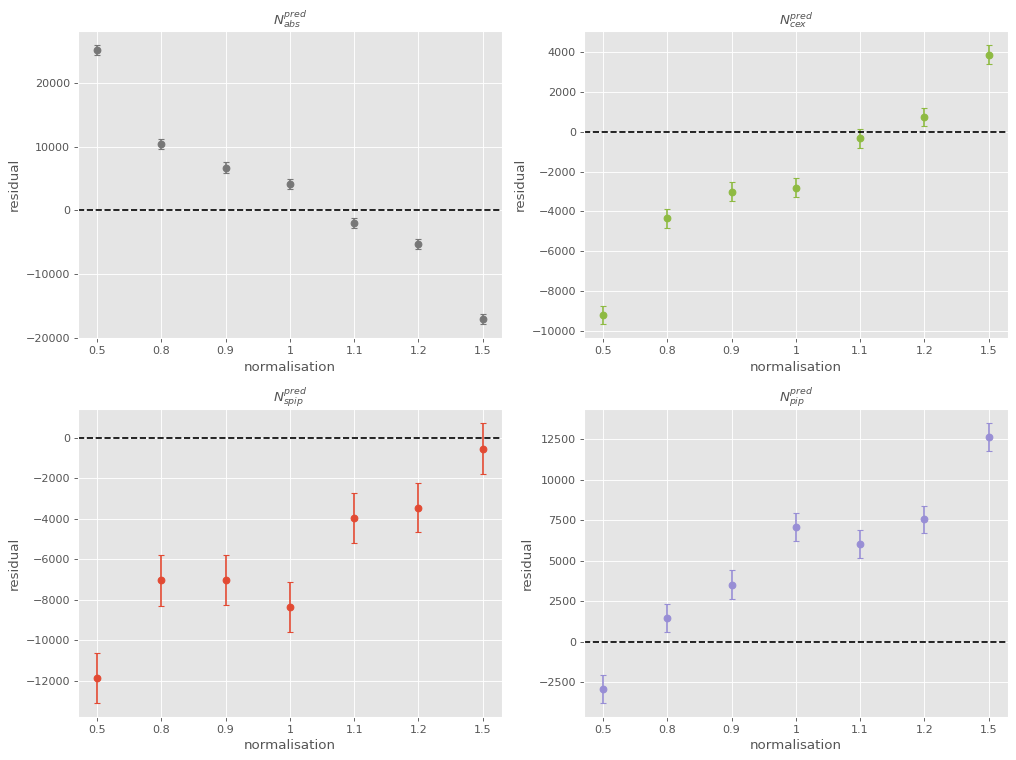

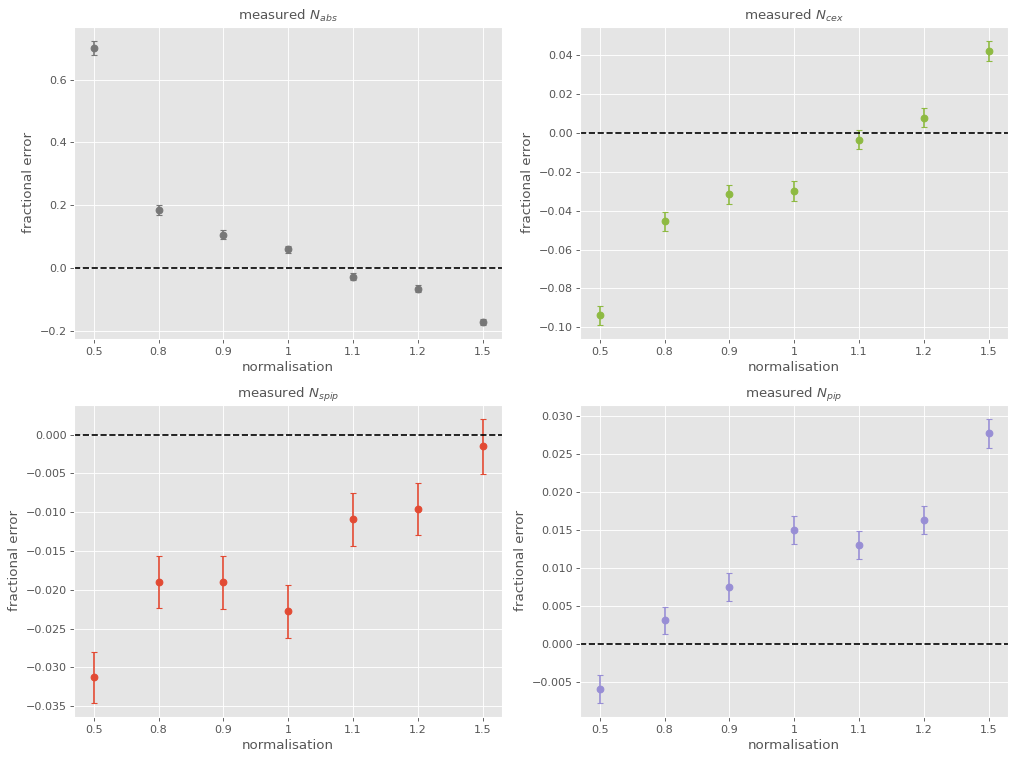

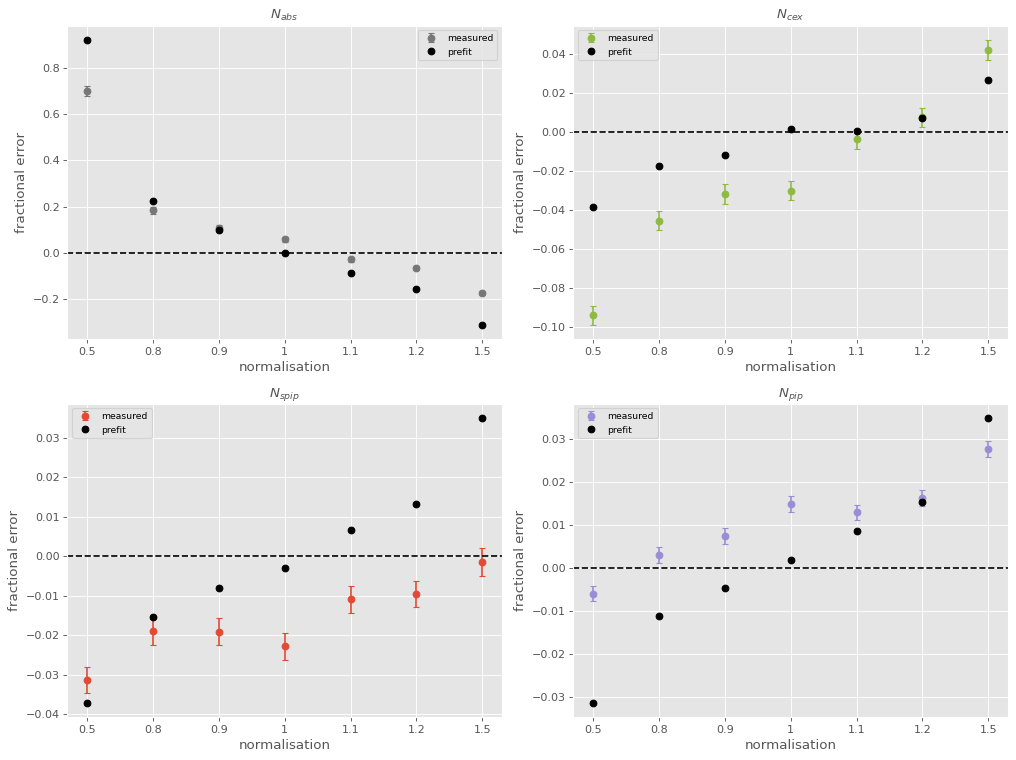

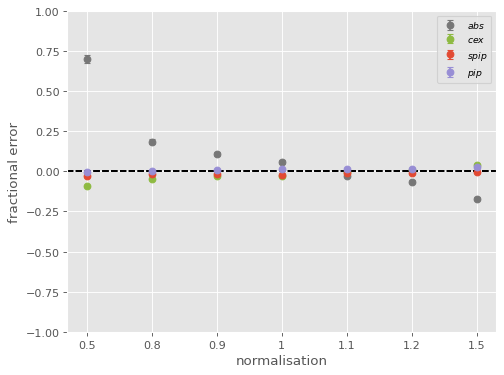

<Figure size 512x384 with 0 Axes>

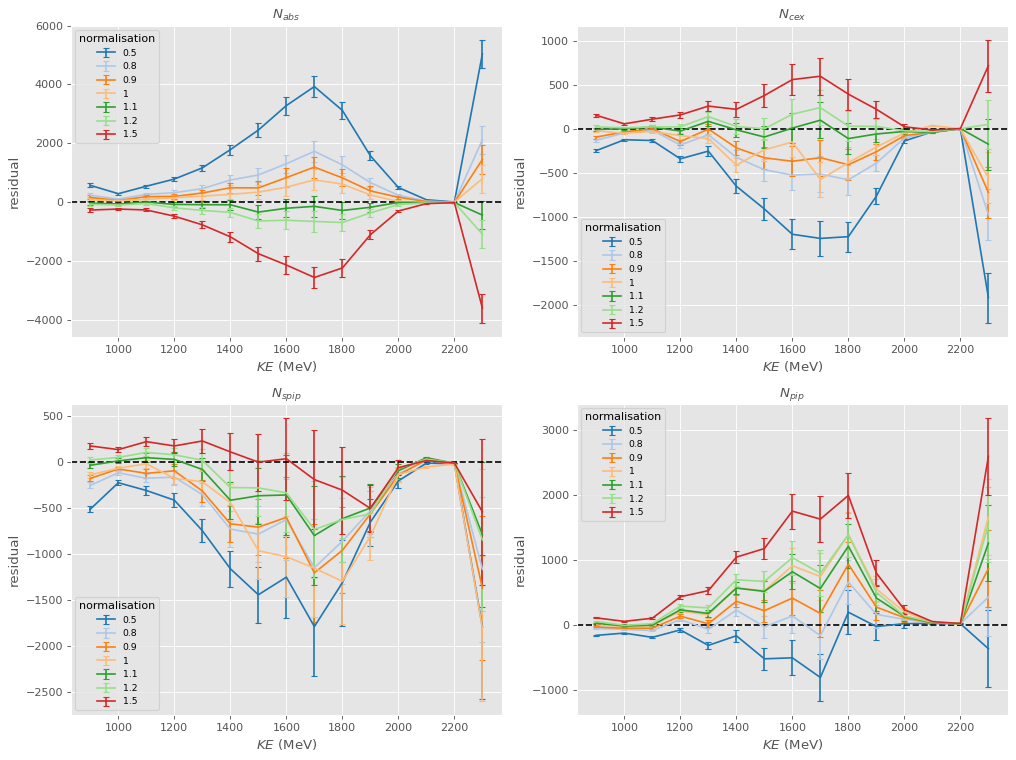

<Figure size 512x384 with 0 Axes>

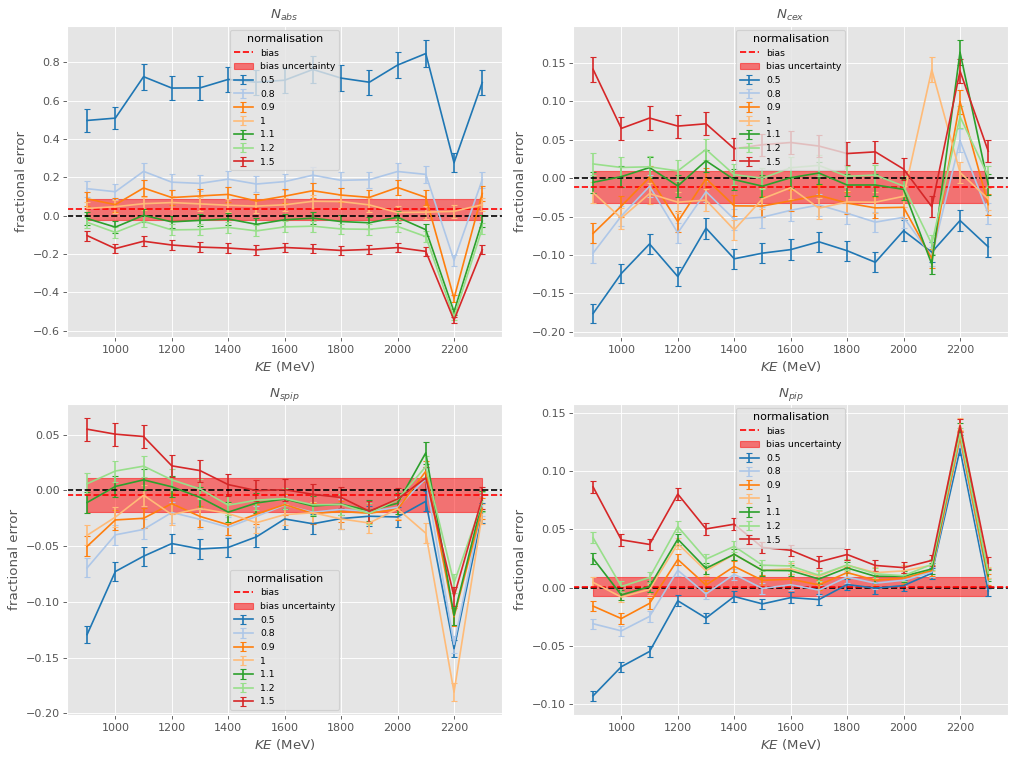

In [114]:
cex_fit_studies.PlotCrossCheckResults("normalisation", models["normal"], ai_template, results["results"], results["true_counts"], energy_overflow, pulls = pull_results)

# modified PDF shapes

## parameterisation

In [6]:
xs_sim = cross_section.GeantCrossSections(energy_range = [0, max(energy_range)])

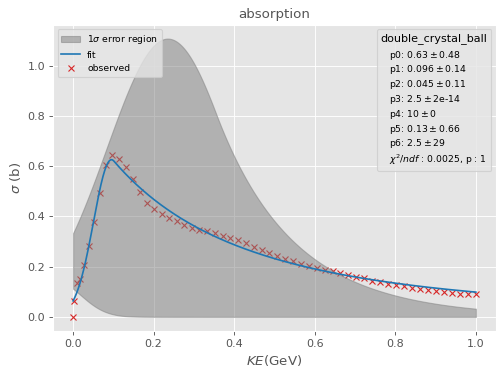

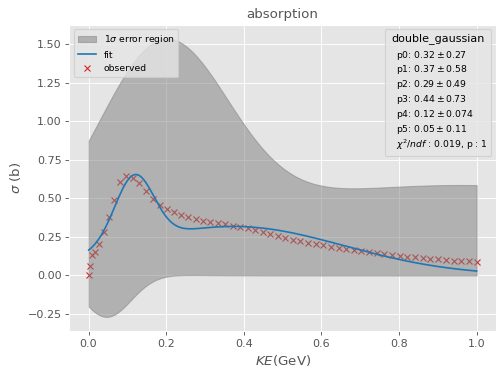

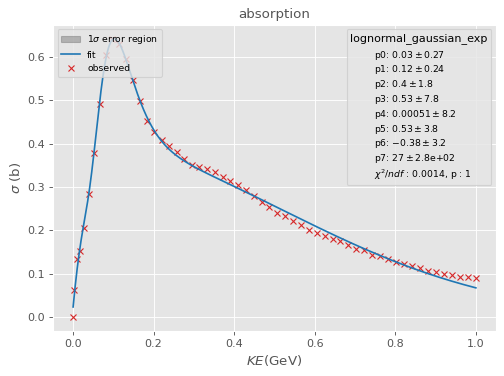

In [12]:
sampling_factor = 20
book = Plots.PlotBook("absorption_fit_attempts.pdf", False)
for f in [cross_section.Fitting.double_crystal_ball, cross_section.Fitting.double_gaussian, cex_fit_studies.lognormal_gaussian_exp]:
    cex_fit_studies.FitSimulationCurve(xs_sim, sampling_factor, "absorption", f, True)
    book.Save()
book.close()

absorption

quasielastic

charge_exchange

double_charge_exchange

pion_production

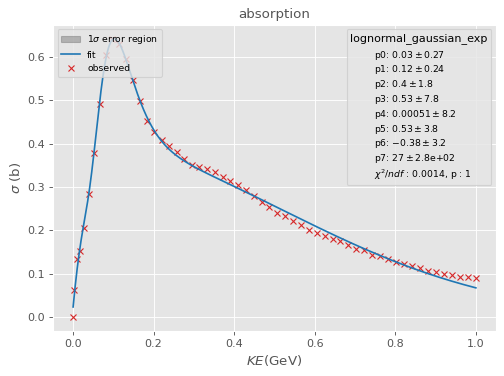

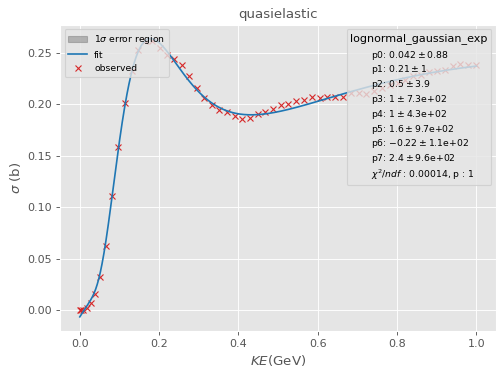

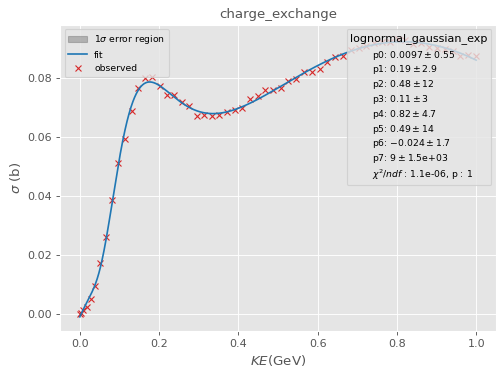

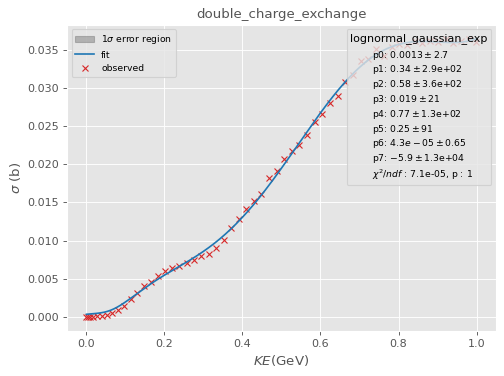

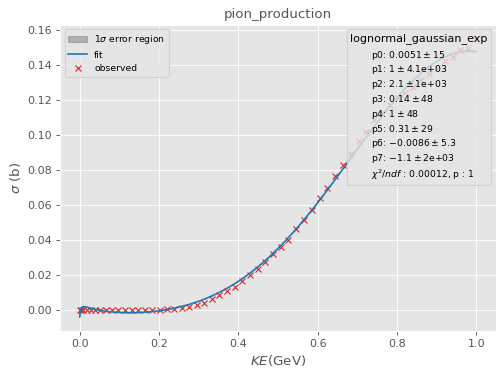

In [16]:
with Plots.PlotBook("xs_curve_fits.pdf", False) as book:
    xs_fit_results = {}
    for i in xs_sim.exclusive_processes:
        print(i)
        xs_fit_results[i] = cex_fit_studies.FitSimulationCurve(xs_sim, 20, i, cex_fit_studies.lognormal_gaussian_exp, True)
        book.Save()

/home/sb16165/Documents/pi0-analysis/analysis/apps/cex_fit_studies.py:100: RuntimeWarning: overflow encountered in exp
  exponential_component = np.exp(-p7 * x)
/home/sb16165/Documents/pi0-analysis/analysis/apps/cex_fit_studies.py:101: RuntimeWarning: overflow encountered in multiply
  return p0 * lognormal_component + p3 * gaussian_component + p6 * exponential_component # Adjust weights as needed


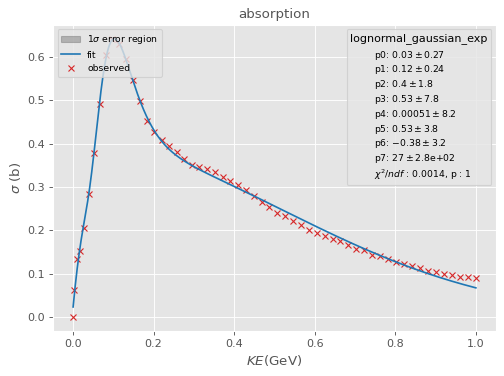

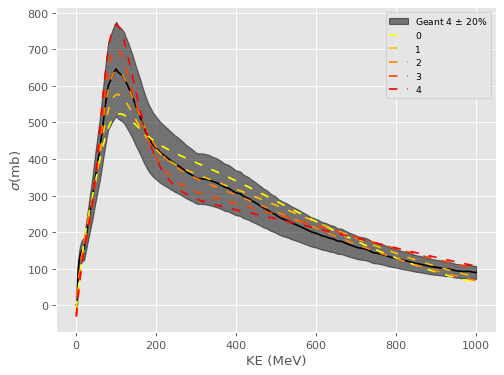

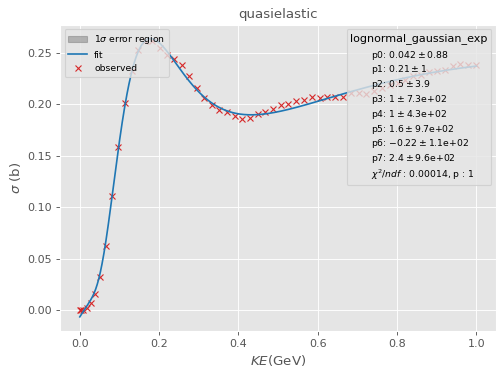

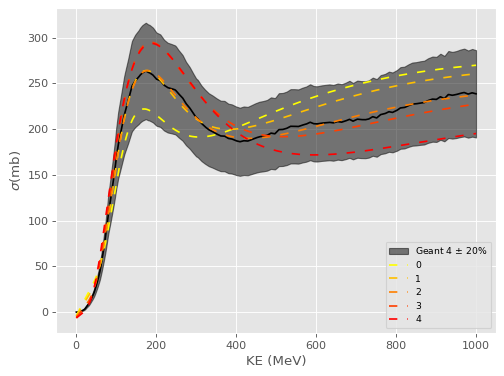

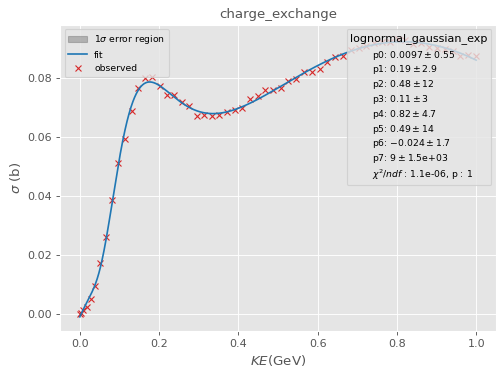

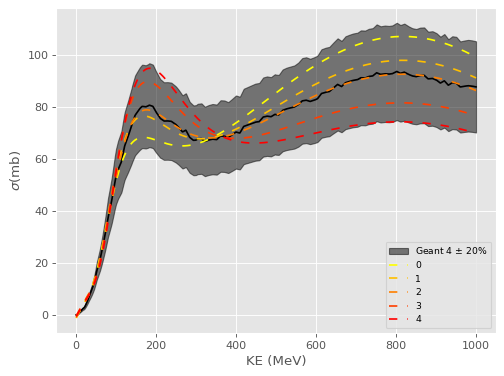

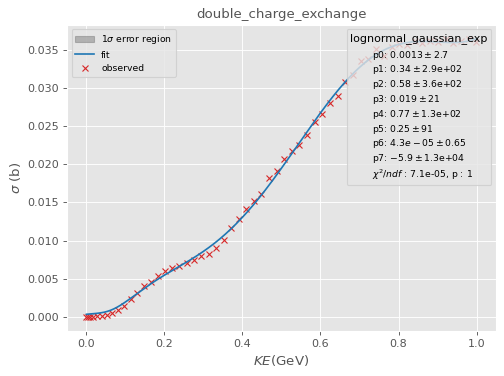

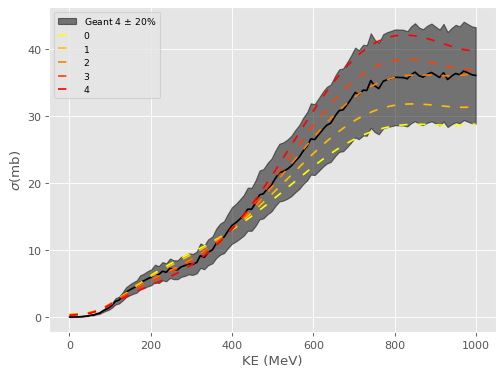

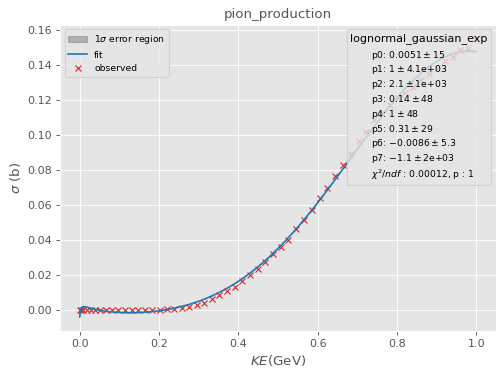

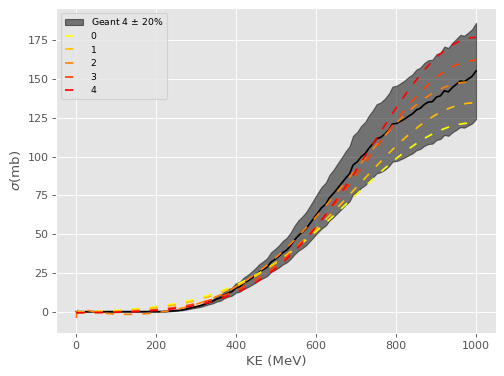

In [14]:
for k, v in cex_fit_studies.shape_param_factors.items():
    cex_fit_studies.CreateShapeParams(xs_sim, k, v[0], v[1])

## spline

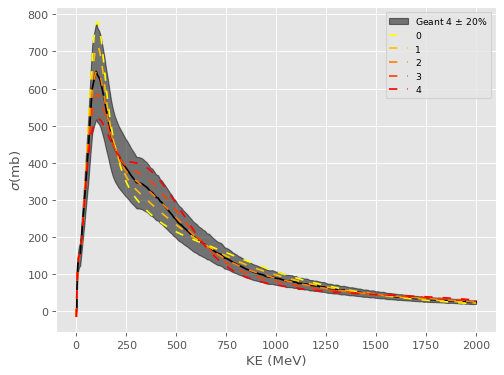

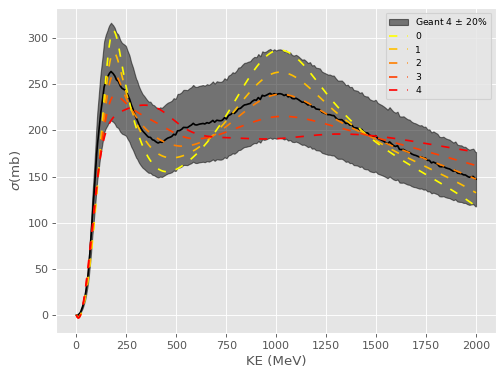

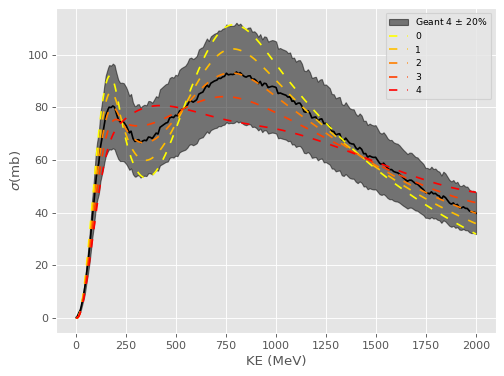

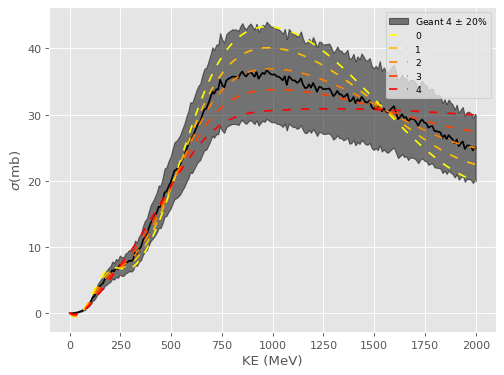

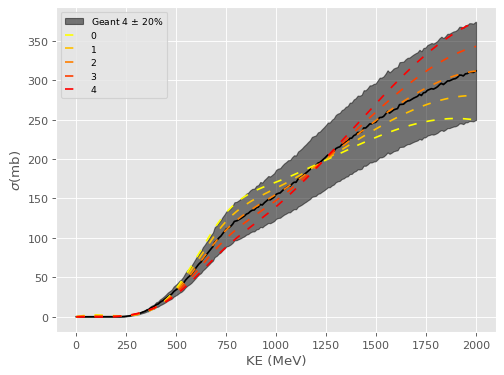

In [177]:
xs_sim = cross_section.GeantCrossSections(energy_range = [0, 2000])

for k in cex_fit_studies.spline_shape_param_factors:
    cex_fit_studies.CreateShapeParamsSpline(xs_sim, k, cex_fit_studies.spline_point_index, cex_fit_studies.spline_shape_param_factors)

## step function

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


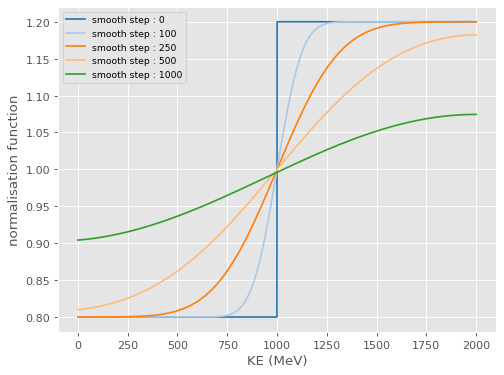

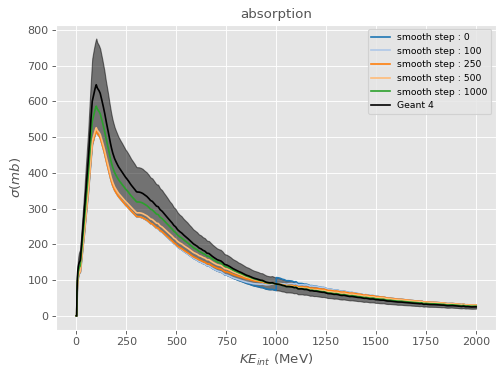

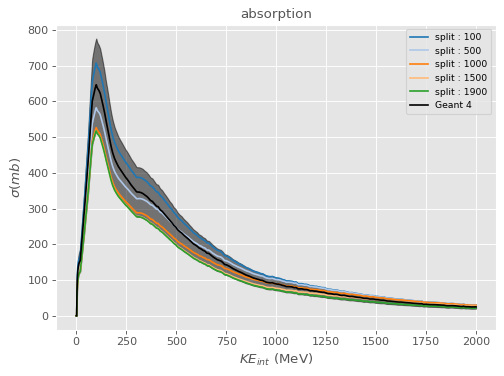

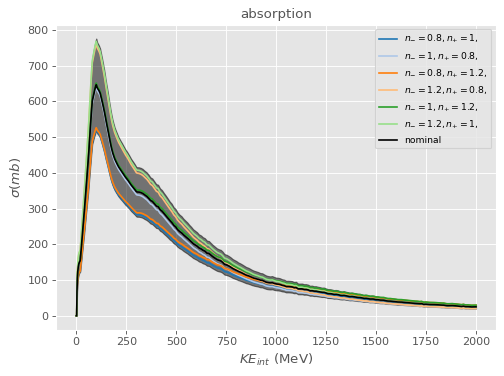

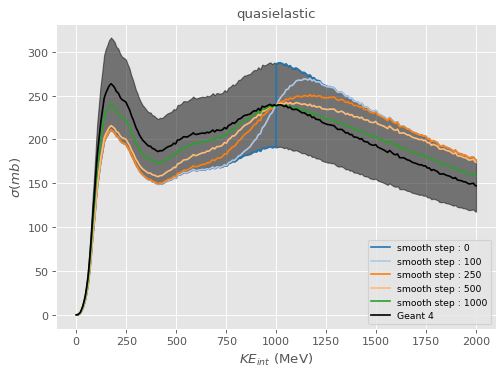

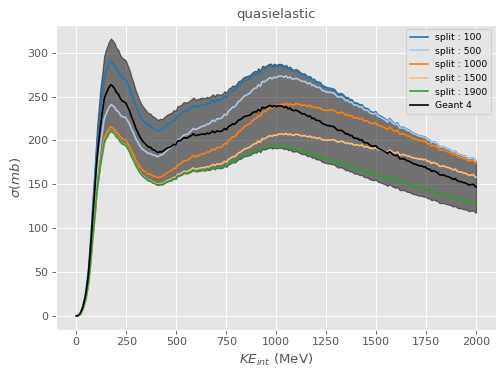

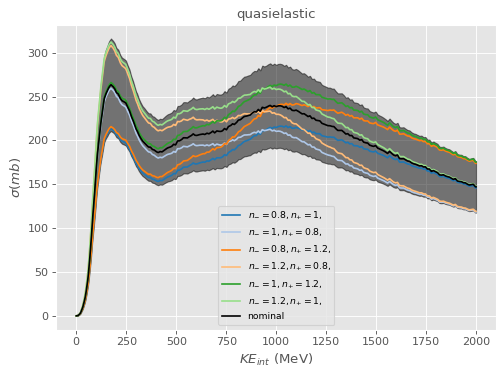

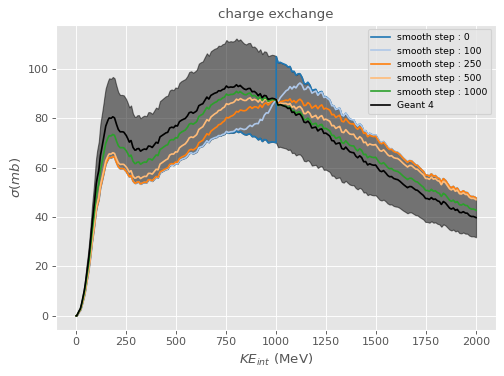

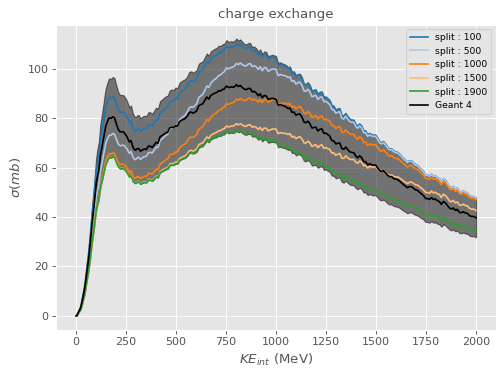

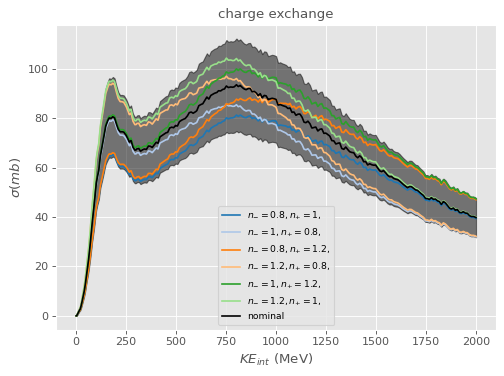

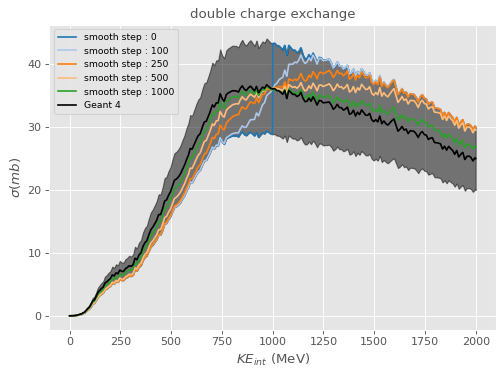

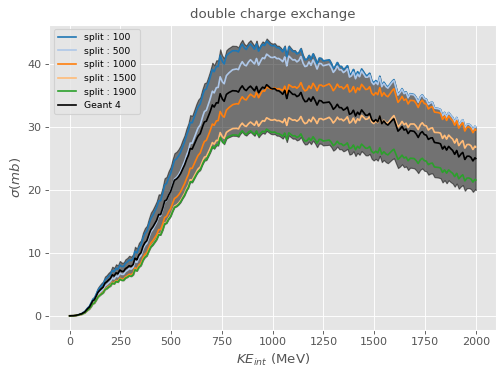

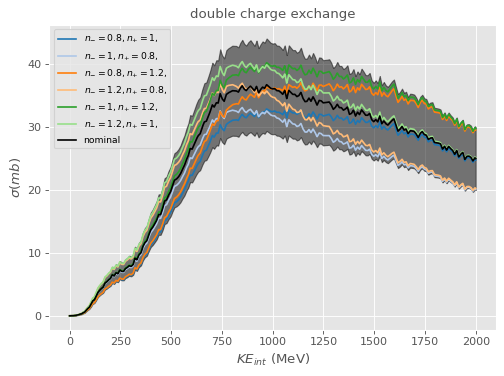

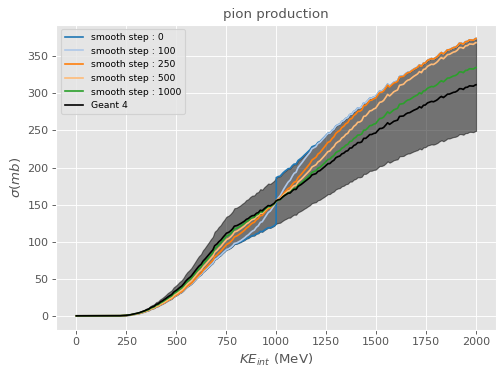

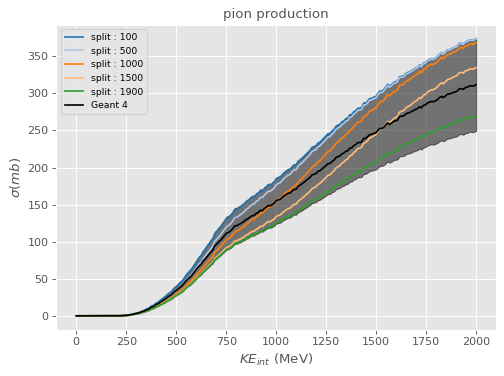

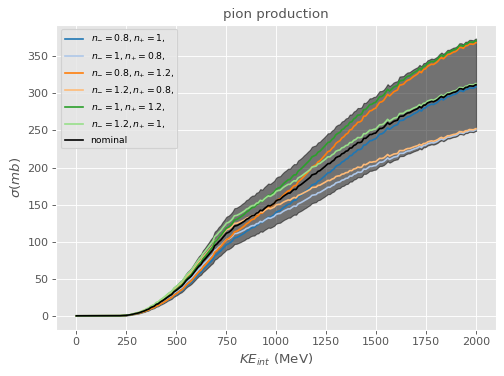

In [13]:
cex_fit_studies.PlotShapeExamples()

In [ ]:
data_config = cross_section.LoadConfiguration("work/2023/toys/cex_toy_config_2GeV.json")
data_config["verbose"] = False
data_config["events"] = 1E4
data_config["step"] = 2
cex_fit_studies.ShapeTestNew("test/new_shape/", data_config, models["normal"], ai_template, None, cross_section.GeantCrossSections(energy_range = [0, max(energy_slice.pos) + energy_slice.width]), energy_slice)

In [4]:
results = cross_section.LoadObject("test/new_shape_test/shape_test_normal/fit_results_abs.dill")
data = cex_fit_studies.ProcessResults(ai_template, results["results"], results["true_counts"], models["normal"])

data_energy = cex_fit_studies.ProcessResultsEnergy(results["results"], results["true_counts"], models["normal"])


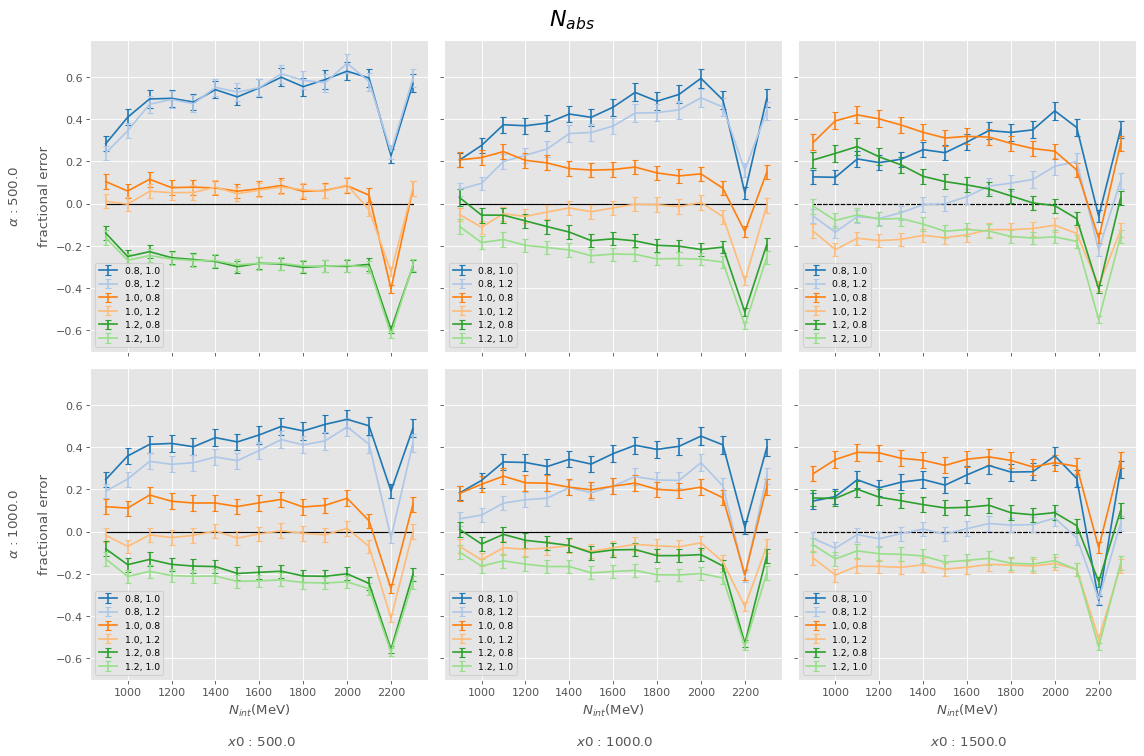

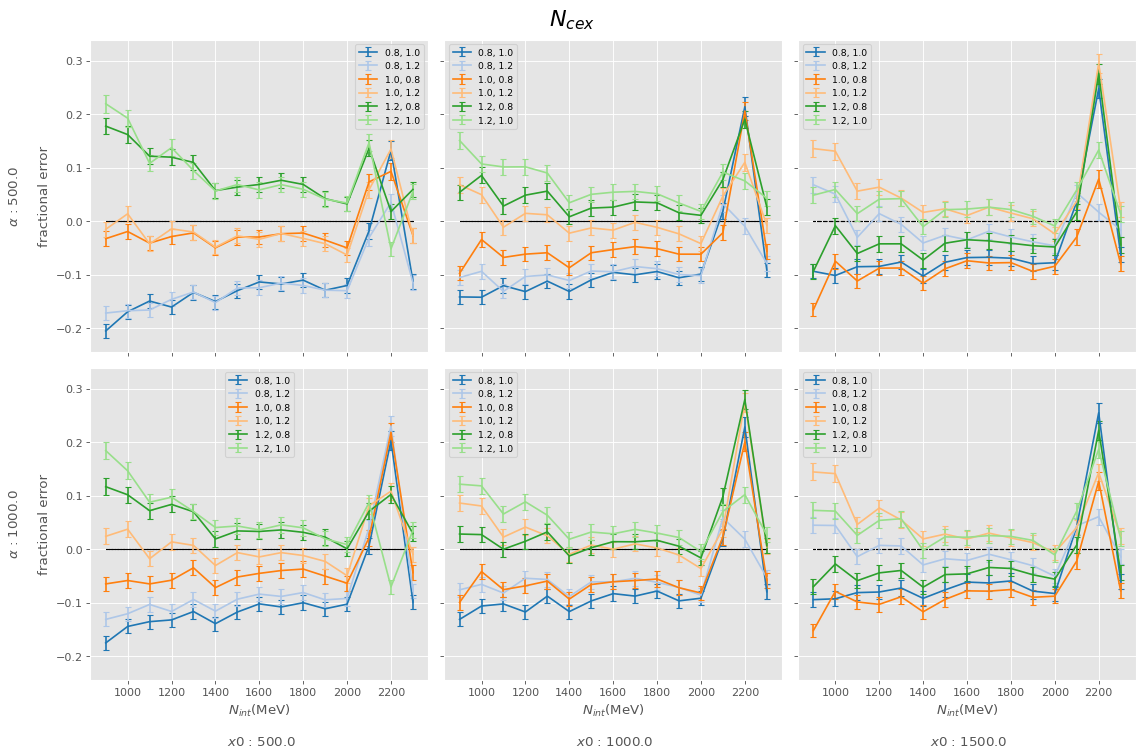

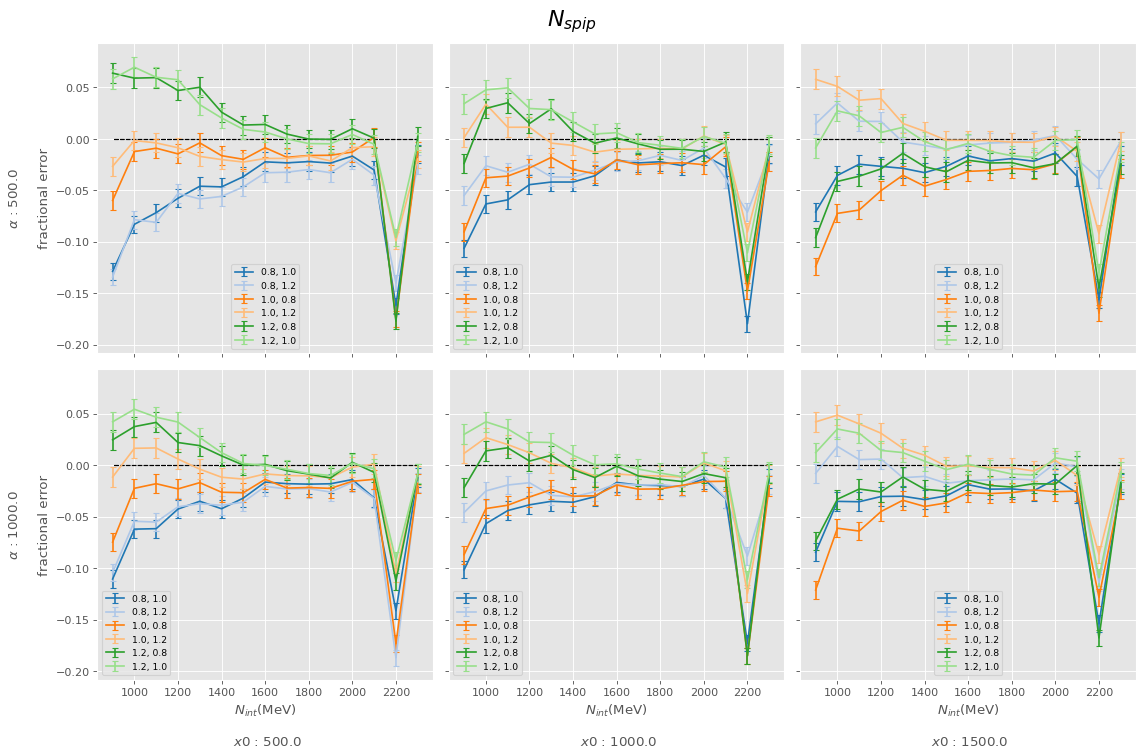

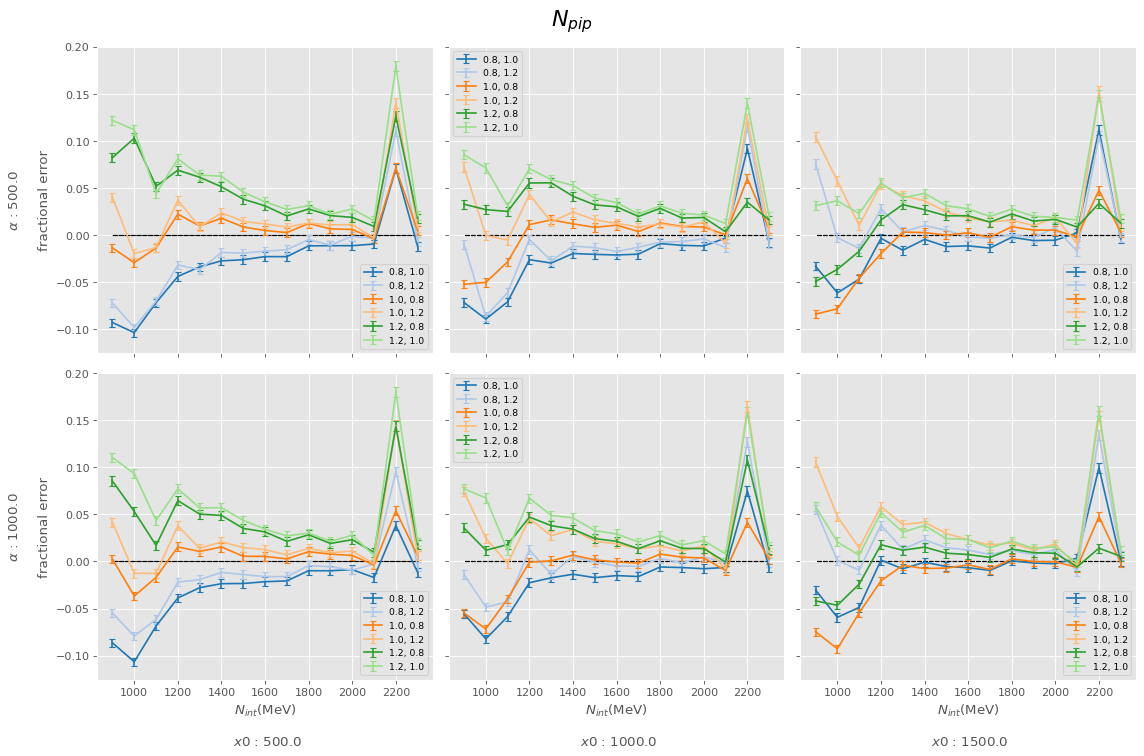

In [13]:
cex_fit_studies.PlotDataShapeTestEnergy(data_energy)

/tmp/ipykernel_15924/3992344719.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


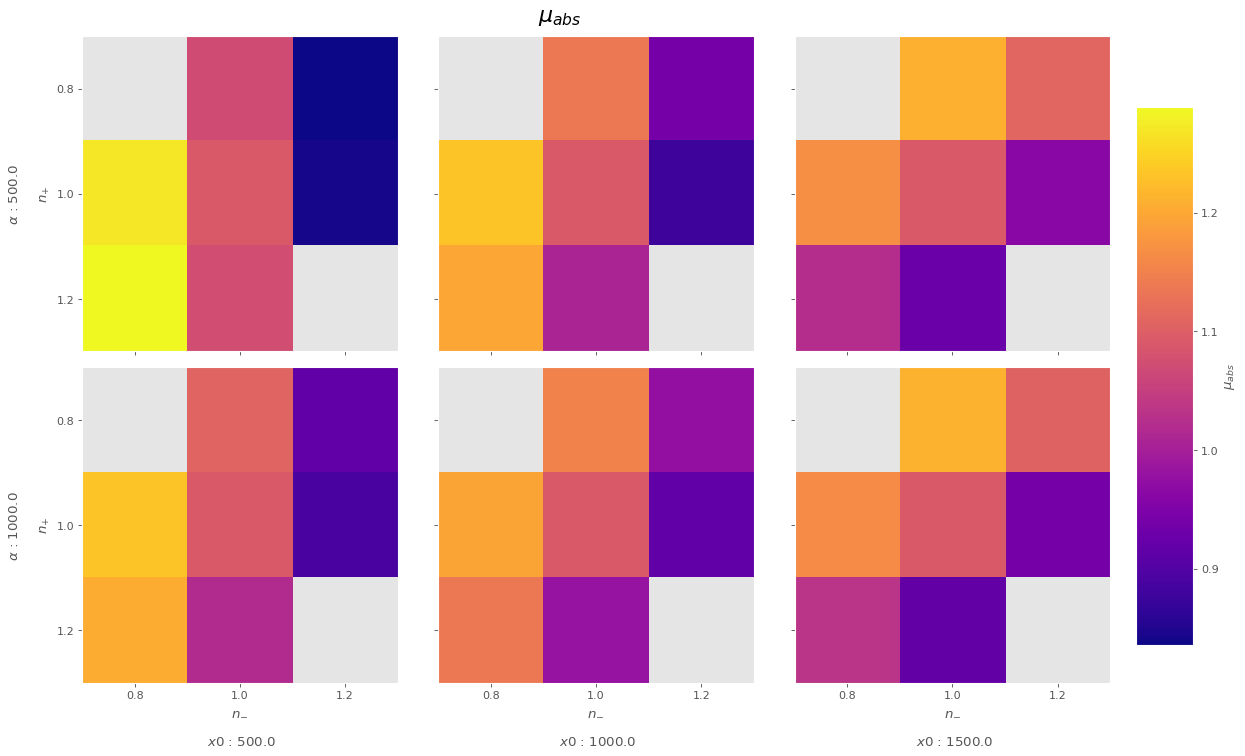

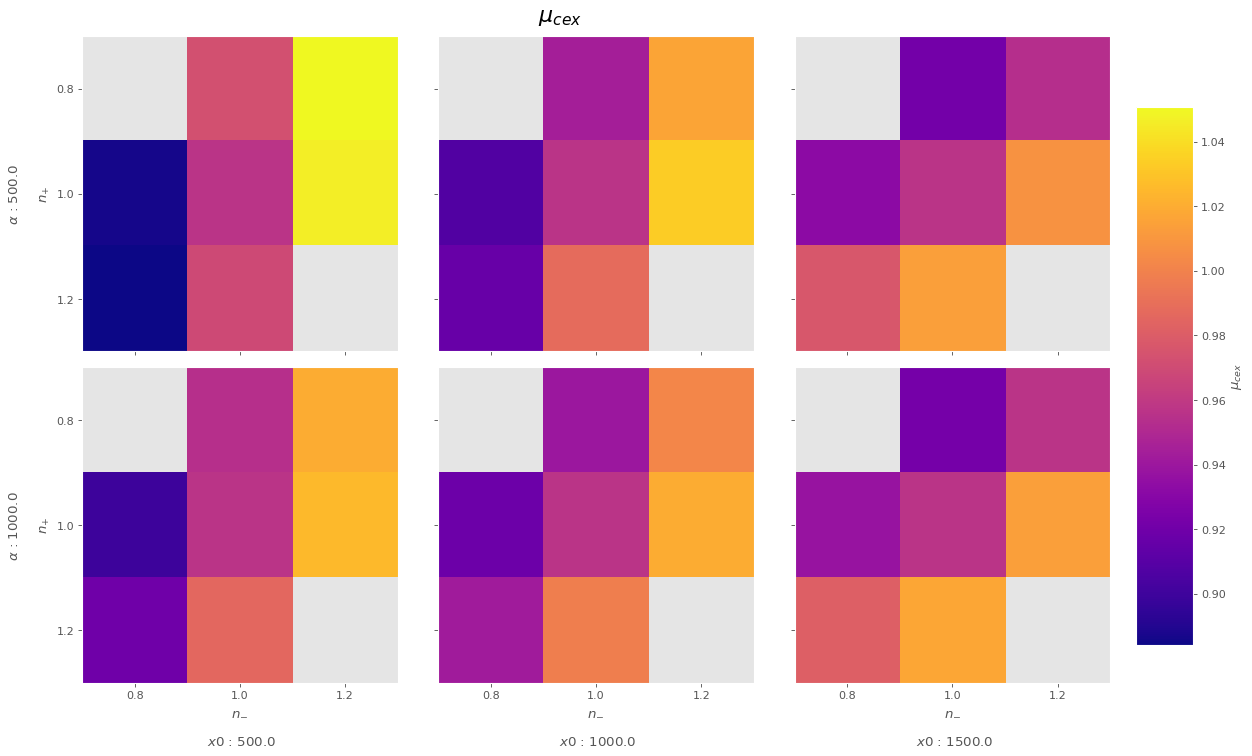

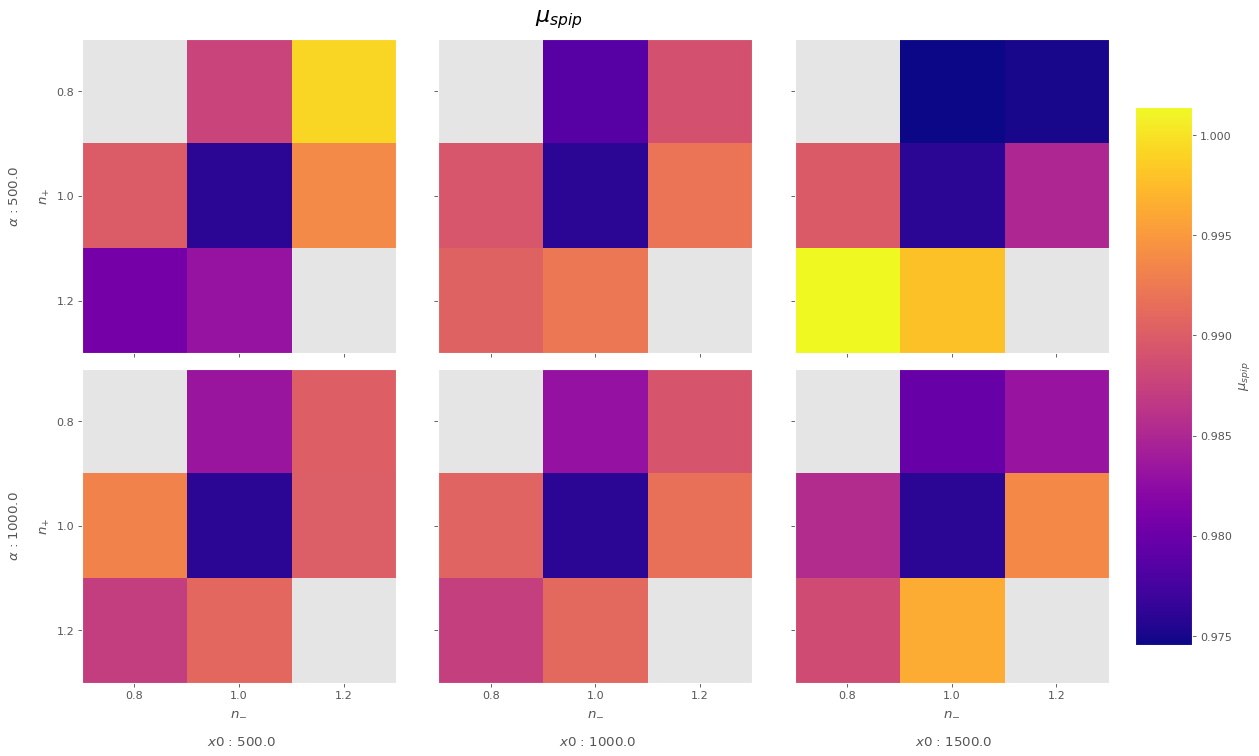

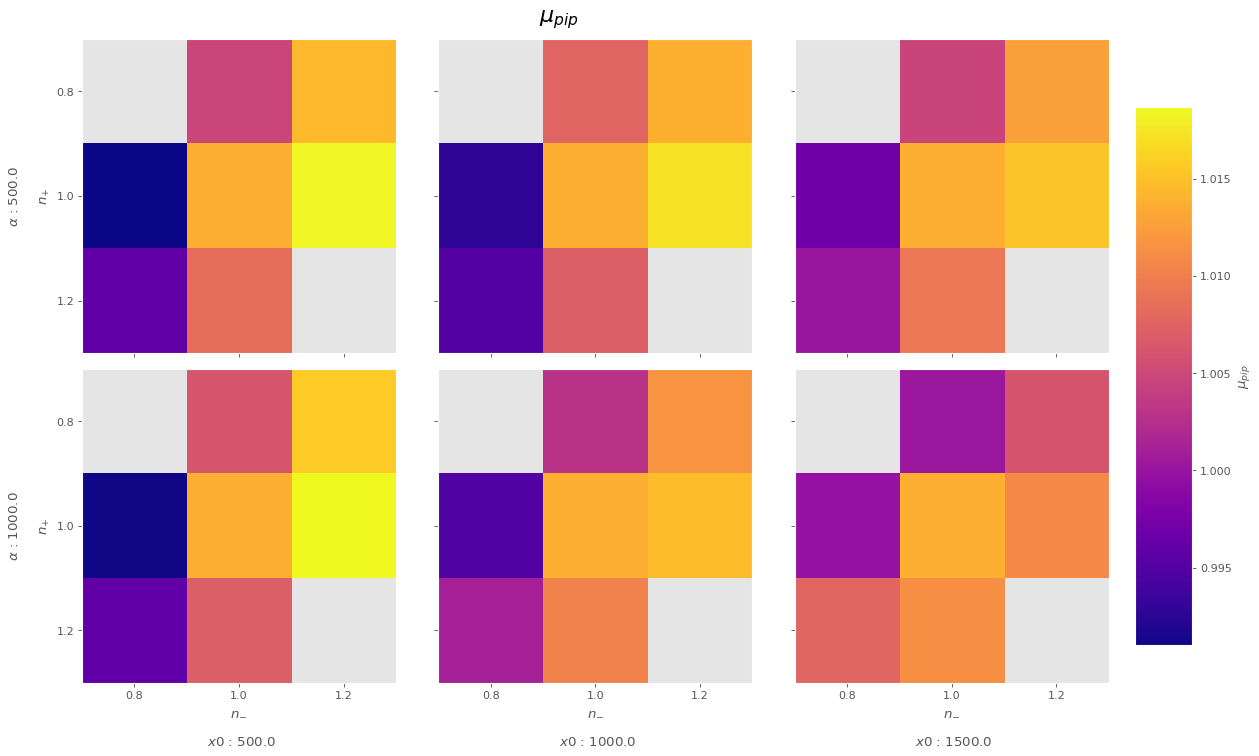

In [7]:
cex_fit_studies.PlotDataShapeTest(data, "mu_0", "$\mu_{abs}$")
cex_fit_studies.PlotDataShapeTest(data, "mu_1", "$\mu_{cex}$")
cex_fit_studies.PlotDataShapeTest(data, "mu_2", "$\mu_{spip}$")
cex_fit_studies.PlotDataShapeTest(data, "mu_3", "$\mu_{pip}$")

## shape test

In [ ]:
xs_sim = cross_section.GeantCrossSections(energy_range = [0, 1000])
cex_fit_studies.ShapeTest(
    directory = "test/test/",
    data_config = CreateConfig(**{"PDSP" : 1, "p_init" : 1000, "seed" : 1, "events" : 1E4, "step" : 2}),
    method = "function",
    shape_param_factors = cex_fit_studies.shape_param_factors,
    spline_shape_param_factors = None,
    xs_sim = xs_sim,
    model = models["normal"],
    toy_template = toy_template,
    mean_track_score_bins = None,
    energy_slices = energy_slice
    )

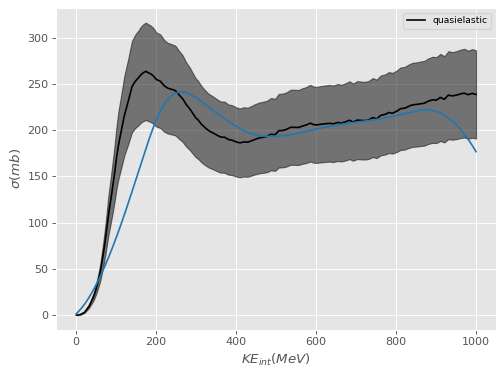

In [176]:
from scipy.ndimage import gaussian_filter1d

y = np.convolve(xs_sim.quasielastic, np.linspace(0, 1, 300), mode = "full")

excess = len(y) - len(xs_sim.KE)

norm = sum(xs_sim.quasielastic) / sum(y)

# Plots.Plot(np.linspace(0, 10, 50), np.exp(-np.linspace(0, 10, 50)))

xs_sim.Plot("quasielastic", color = "k")
Plots.plt.fill_between(xs_sim.KE, 0.8 * xs_sim.quasielastic, 1.2 * xs_sim.quasielastic, color = "k", alpha = 0.5)
Plots.Plot(xs_sim.KE, norm * y[excess//2 : -excess//2], newFigure = False)
# Plots.plt.xlim(0, 950)

# Pull study

In [ ]:
# config = CreateConfig(seed = None, events = 1E6, verbose = False)
# out = PullStudy(toy_template, models["normal"], config, 100)
out = cex_fit_studies.PullStudy(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template), models["normal"], energy_slice, CreateConfig(PDSP = 2, p_init = 2000, step = 2, events = 1E4), 100)

In [11]:
DictToHDF5(out, "test/2GeV_pull_study.hdf5")

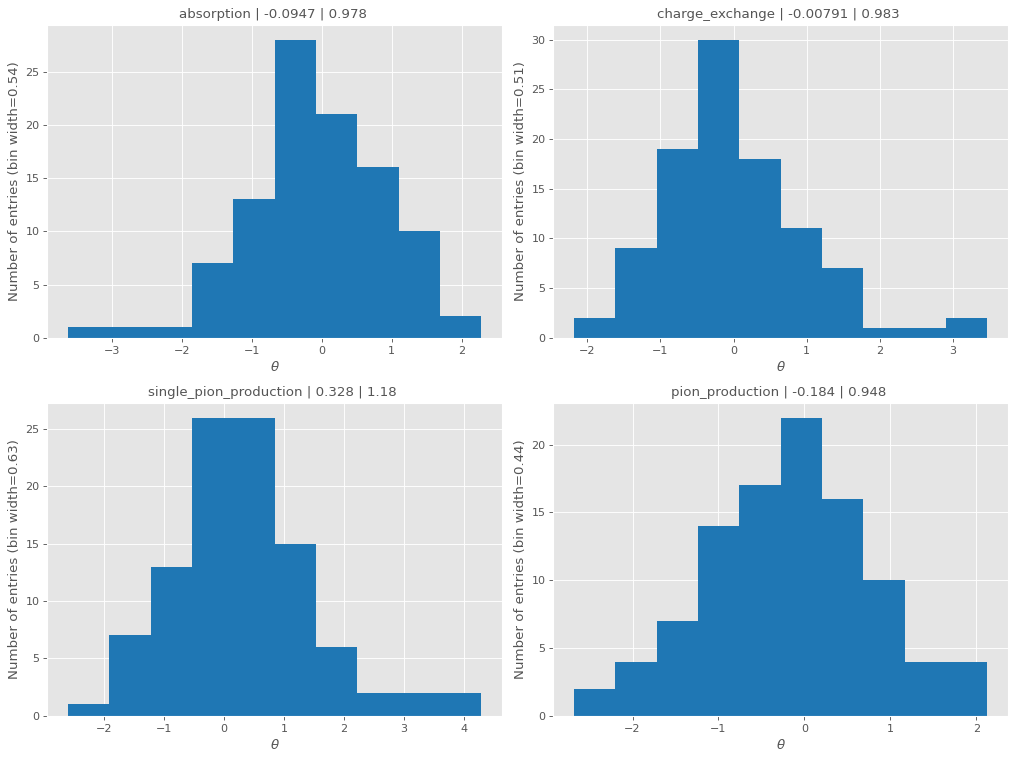

In [12]:
with Plots.PlotBook("pulls_1E6.pdf", False) as book:
    out = ReadHDF5("test/2GeV_pull_study.hdf5")

    pulls = (out["bestfit"] - (out["expected"] / out["scale"][0])) / out["uncertainty"]

    xlabel = "$\\theta$"

    for _, k in Plots.IterMultiPlot(pulls.columns):
        Plots.PlotHist(pulls[k], bins = 10, title = f"{k} | {np.mean(pulls[k]):.3g} | {np.std(pulls[k]):.3g} ", xlabel = xlabel, newFigure = False)
    book.Save()

    # out = ReadHDF5("test/1GeV_pull_study_2.hdf5")

    # pulls = (out["bestfit"] - (out["expected"] / out["scale"][0])) / out["uncertainty"]

    # for _, k in Plots.IterMultiPlot(pulls.columns):
    #     Plots.PlotHist(pulls[k], bins = 10, title = f"{k} | {np.mean(pulls[k]):.3g} | {np.std(pulls[k]):.3g} ", xlabel = xlabel, newFigure = False)
    # book.Save()

    # out = ReadHDF5("test/1GeV_pull_study_var.hdf5")

    # pulls = (out["bestfit"] - (out["expected"] / out["scale"][0])) / out["uncertainty"]

    # for _, k in Plots.IterMultiPlot(pulls.columns):
    #     Plots.PlotHist(pulls[k], bins = 10, title = f"{k} | {np.mean(pulls[k]):.3g} | {np.std(pulls[k]):.3g} ", xlabel = xlabel, newFigure = False)
    # book.Save()

# Background subtraction

In [4]:
model_single_bin = cross_section.RegionFit.CreateModel(ai_template, energy_slice, None, False, None, True, True, True)

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_sample_0_pois_err', 'shapesys'), ('channel_0_sample_1_pois_err', 'shapesys'), ('channel_0_sample_2_pois_err', 'shapesys'), ('channel_0_sample_3_pois_err', 'shapesys'), ('channel_1_sample_0_pois_err', 'shapesys'), ('channel_1_sample_1_pois_err', 'shapesys'), ('channel_1_sample_2_pois_err', 'shapesys'), ('channel_1_sample_3_pois_err', 'shapesys'), ('channel_2_sample_0_pois_err', 'shapesys'), ('channel_2_sample_1_pois_err', 'shapesys'), ('channel_2_sample_2_pois_err', 'shapesys'), ('channel_2_sample_3_pois_err', 'shapesys'), ('channel_3_sample_0_pois_err', 'shapesys'), ('channel_3_sample_1_pois_err', 'shapesys'), ('channel_3_sample_2_pois_err', 'shapesys'), ('channel_3_sample_3_pois_err', 'shapesys'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfa

In [6]:
toy_obs = cross_section.Toy(df = cex_toy_generator.run(cross_section.LoadConfiguration("work/2023/toys/cex_toy_config_2GeV.json")))
toy_obs_ai = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_obs)

starting batch : 0, cpus : 9

starting batch : 1, cpus : 9

starting batch : 2, cpus : 9

starting batch : 3, cpus : 9

starting batch : 4, cpus : 9

starting batch : 5, cpus : 9

starting batch : 6, cpus : 9

starting batch : 7, cpus : 9

starting batch : 8, cpus : 9

starting batch : 9, cpus : 9

starting batch : 10, cpus : 9

starting batch : 11, cpus : 1

Simulating |████████████████████████████████████████| 12/12 [100%] in 56.4s (0.21/s) 


Done! Creating dataframe...

total_inelastic 999962

decay 38

pion_production 470993

quasielastic 314182

charge_exchange 93981

absorption 68786

double_charge_exchange 52020

38

'BeamSelectionEfficiency' executed in 0.0710s

'GenerateRecoRegions' executed in 1.9949s

'MeanTrackScore' executed in 3.9864s

'main' executed in 66.4817s

In [9]:
pred, fit_result = cex_analyse.RegionFit(toy_obs_ai, energy_slice, None, model_single_bin, False, None, True, True, True)

n_int=[320324]
n_int=[20415]
n_int=[408544]
n_int=[250679]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697287.58136533])


In [39]:
N_bkg_s = cross_section.RegionFit.EstimateBackgroundInRegions(pred, toy_obs_ai)
N_bkg_b = {}
N_bkg_err_b = {}
for p in N_bkg_s[0]:
    N_bkg_b[p], N_bkg_err_b[p] = cex_analyse.BkgSingleBin(N_bkg_s[0][p], N_bkg_s[1][p], ai_template, energy_slice, p)


# N_bkg_s = cross_section.RegionFit.EstimateBackgroundAllRegions(pred, ai_template, "charge_exchange")
# cex_analyse.BkgSingleBin(N_bkg_s[0], N_bkg_s[1], ai_template, energy_slice, "charge_exchange")

In [50]:
N_ex, N_ex_err = cex_analyse.BkgSubRegions(toy_obs_ai, energy_slice, N_bkg_b, N_bkg_err_b)

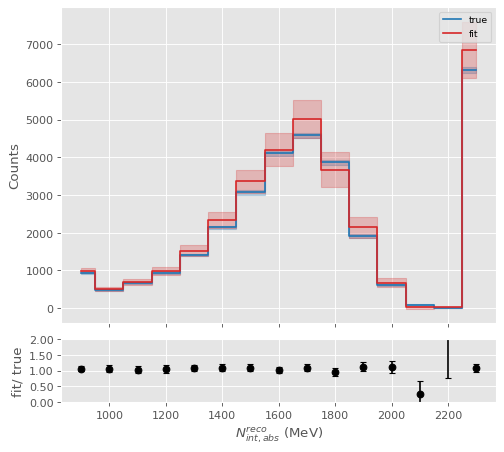

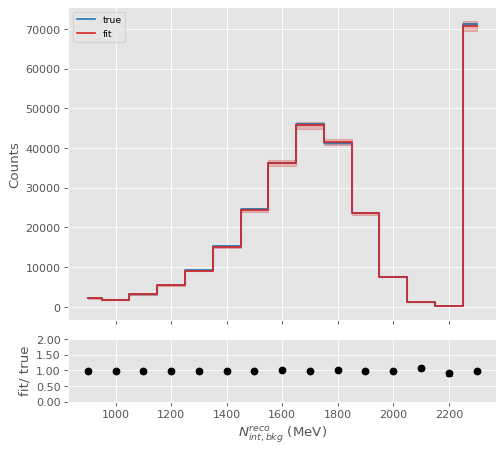

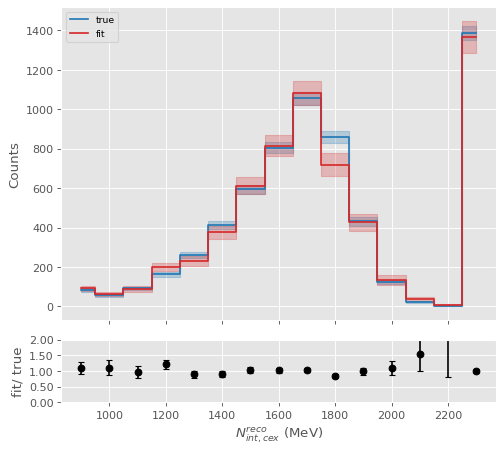

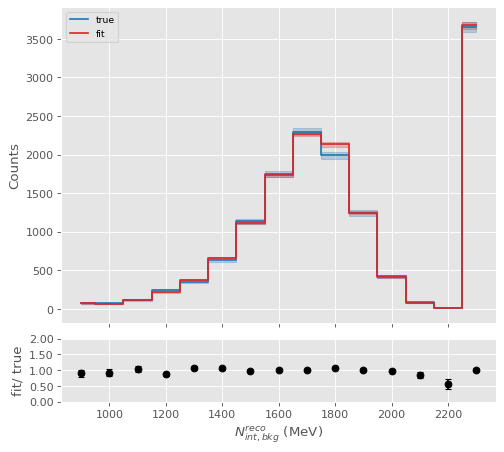

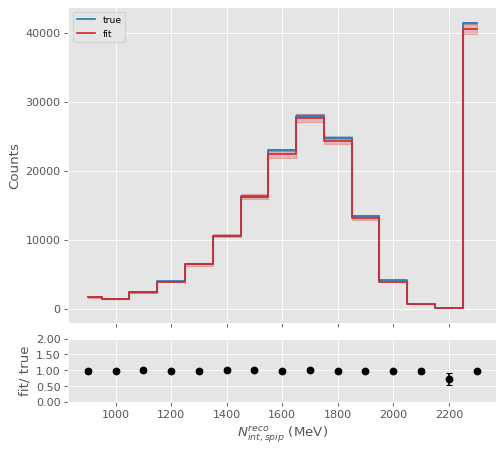

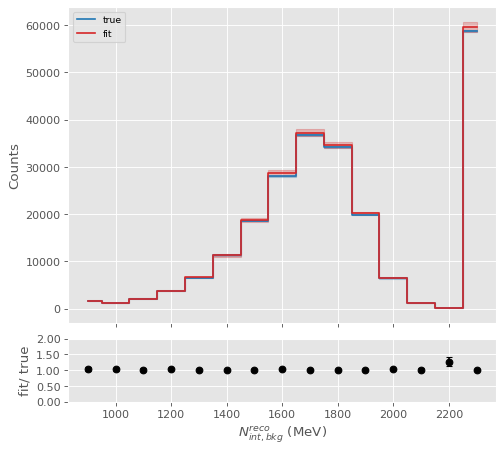

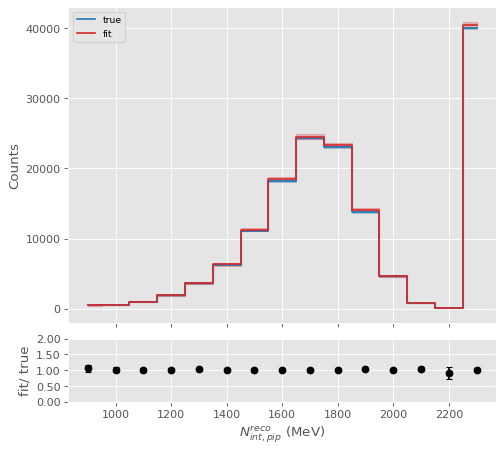

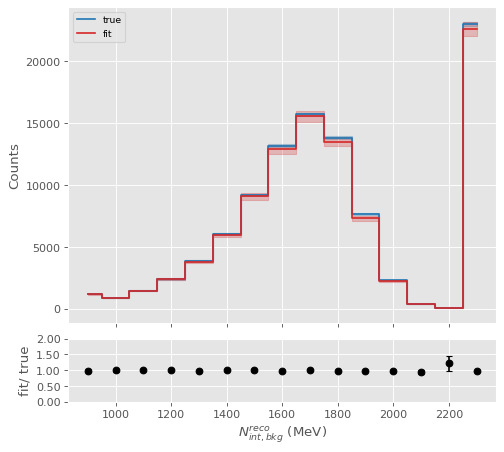

In [59]:
process = "charge_exchange"
labels = list(toy_obs_ai.regions.keys()) #! make property of AnalysisInput dataclass

if toy_obs_ai.exclusive_process is not None:
    energy_bins = np.sort(np.insert(energy_slice.pos, 0, energy_slice.max_pos + energy_slice.width))

    if type(N_ex) == dict: #* replace with if regions:
        for i in N_ex:
            actual = {l : toy_obs_ai.NInteract(energy_slice, toy_obs_ai.exclusive_process[l], mask = toy_obs_ai.regions[i], weights = toy_obs_ai.weights) for l in labels}

            actual_sig = actual[i]
            actual_bkg = sum(np.array(list(actual.values()))[i != np.array(labels)])
            cross_section.RegionFit.PlotPrefitPostFit(actual_sig, np.sqrt(actual_sig), N_ex[i], N_ex_err[i], energy_bins, f"$N^{{reco}}_{{int,{cex_analyse.process_labels[i]}}}$ (MeV)")
            cross_section.RegionFit.PlotPrefitPostFit(actual_bkg, np.sqrt(actual_bkg), np.sum(N_bkg_b[i], 0), np.sum(N_bkg_err_b[i], 0), energy_bins, "$N^{reco}_{int,bkg}$ (MeV)")

    else:
        actual = {l : toy_obs_ai.NInteract(energy_slice, toy_obs_ai.exclusive_process[l], weights = data.weights) for l in labels}
        actual_sig = actual[process]
        actual_bkg = sum(np.array(list(actual.values()))[process != np.array(labels)])
        cross_section.RegionFit.PlotPrefitPostFit(actual_sig, np.sqrt(actual_sig), N_ex, N_ex_err, energy_bins, f"$N^{{reco}}_{{int,{cex_analyse.process_labels[i]}}}$ (MeV)")

        cross_section.RegionFit.PlotPrefitPostFit(actual_bkg, np.sqrt(actual_bkg), np.sum(N_bkg_b, 0), np.sum(N_bkg_err_b, 0), energy_bins, "$N^{reco}_{int,bkg}$ (MeV)")


In [71]:
_, histograms_data, histograms_data_err = cex_analyse.BackgroundSubtraction(toy_obs_ai, "charge_exchange", energy_slice, pred, True, True, ai_template, None)

histograms_mc_reco = ai_template.CreateHistograms(energy_slice, "charge_exchange", True, False)
histograms_mc_reco.pop("int_ex")

array([207692,    281,   3223,  19995,  66119, 124867, 146661, 124212,
        89455,  59089,  38591,  24608,  14988,   9257,  12250])

# cross check summary

In [9]:
template_counts = sum(ai_template.inclusive_process)

'PredictedCountsSummary' executed in 0.0233s

absorption(\%) charge exchange(\%)  \
absorption               21.8 $\pm$ 1       5.7 $\pm$ 0.5   
single pion production    9.0 $\pm$ 1       2.9 $\pm$ 0.5   
pion production          26.5 $\pm$ 1       6.4 $\pm$ 0.5   
charge exchange           8.6 $\pm$ 1       3.9 $\pm$ 0.6   

                       single pion production(\%) pion production(\%)  
absorption                          2.3 $\pm$ 0.3       1.7 $\pm$ 0.2  
single pion production              3.5 $\pm$ 0.3       3.3 $\pm$ 0.2  
pion production                     3.1 $\pm$ 0.3       5.3 $\pm$ 0.2  
charge exchange                     2.9 $\pm$ 0.4       2.1 $\pm$ 0.2

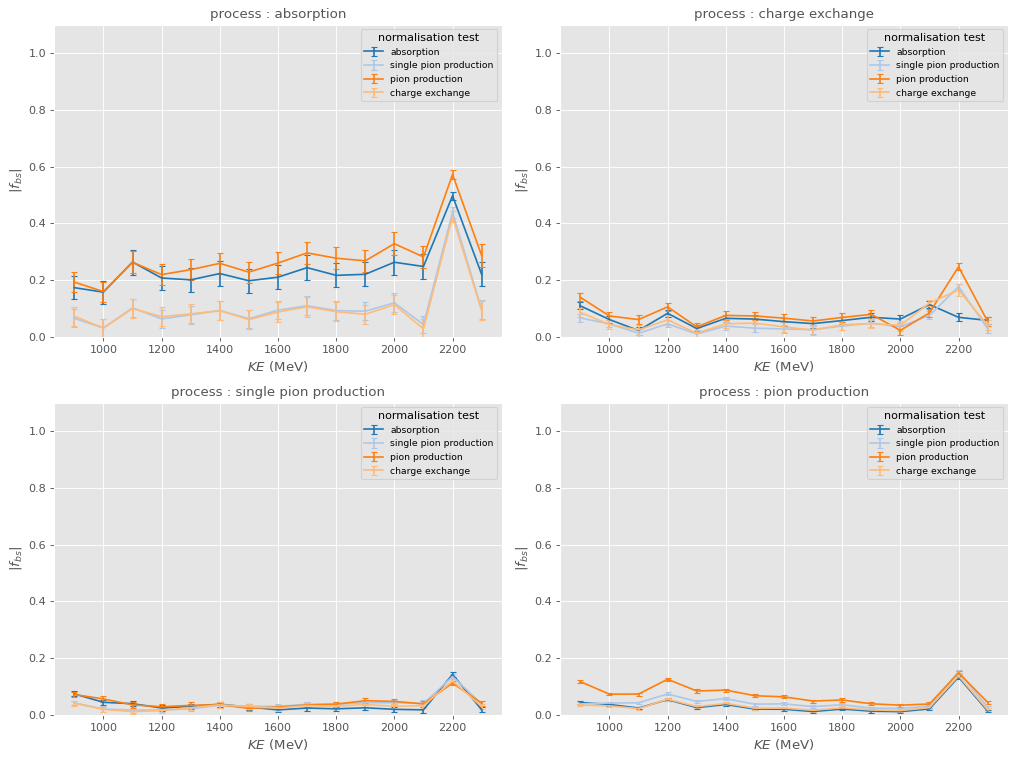

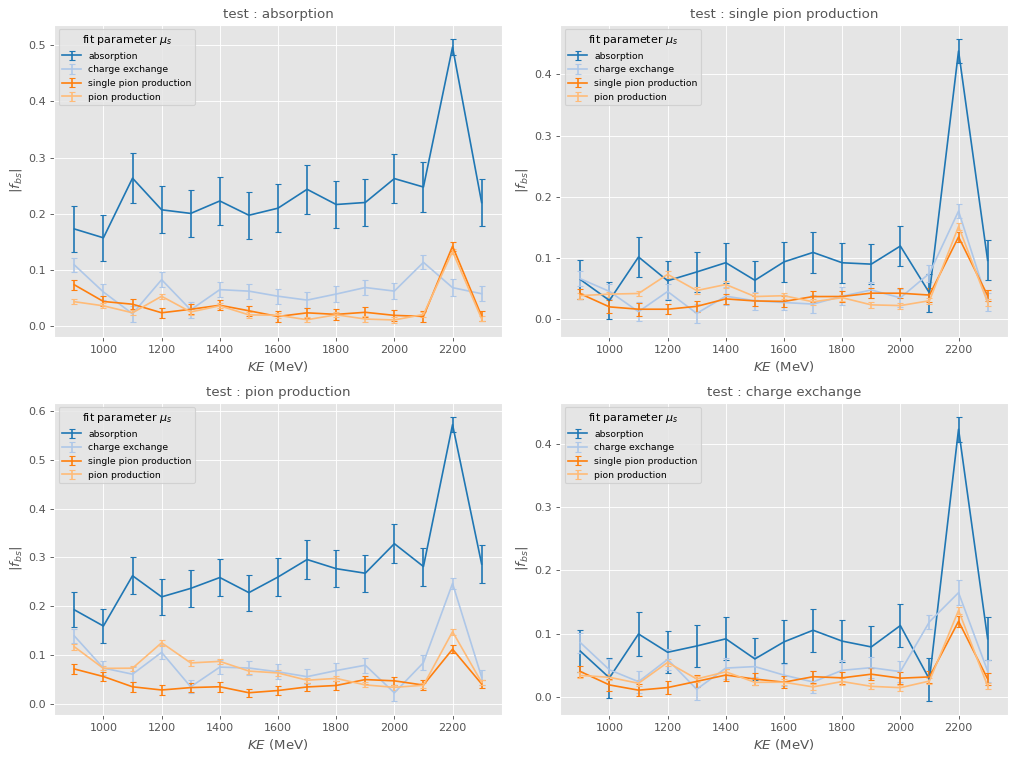

In [42]:
def PlotNew(directory, model, test, ymax, book : Plots.PlotBook = Plots.PlotBook.null):
    n_fe_max, n_fe_total_max = cex_fit_studies.PredictedCountsSummary(directory, model, test)

    indices = ["absorption", "charge_exchange", "single_pion_production", "pion_production"]
    xlabel = "$KE$ (MeV)"

    tables_n = cex_fit_studies.CreateSummaryTables(n_fe_total_max, indices)
    cex_fit_studies.SaveSummaryTables(directory, tables_n, "processes")
    print(tables_n[2])

    if ymax is None:
        ymax = np.max([n_fe_max[t][0] for t in n_fe_max])

    for i, p in Plots.IterMultiPlot(indices):
        for j, t in enumerate(n_fe_max):
            y = n_fe_max[t][0]
            err = n_fe_max[t][1]
            Plots.Plot(energy_overflow, y[i], yerr = err[i], color = f"C{j}", label = cross_section.remove_(t), ylabel = "$|f_{bs}|$", xlabel = xlabel, title = f"process : {cross_section.remove_(p)}", newFigure = False)
            Plots.plt.ylim(0, 1.1 * ymax)
        Plots.plt.legend(title = f"{test} test")
    book.Save()

    for i, t in Plots.IterMultiPlot(n_fe_max):
        for j, p in enumerate(indices):
            y = n_fe_max[t][0]
            err = n_fe_max[t][1]
            Plots.Plot(energy_overflow, y[j], yerr = err[j], xlabel = xlabel, ylabel = "$|f_{bs}|$", label = cross_section.remove_(p), title = f"test : {cross_section.remove_(t)}", newFigure = False)
        Plots.plt.legend(title = "fit parameter $\mu_{s}$")


directory = "test/cross_checks_2GeV_new/normalisation_test_normal/"
results_files = [i for i in cross_section.os.listdir(directory) if "dill" in i]

for f in results_files:
    fit_result = cross_section.LoadObject(directory+f)
    target = [cex_fit_studies.target_map[k] for k in cex_fit_studies.target_map if k in f][0]
    PlotNew(directory, models["normal"], "normalisation", ymax = 1)
    break

# Computing $KE^{fit}_{int}$

In [5]:
# toy_observed = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(PDSP = 1, p_init = 1000, seed = 1))), smearing = True)
toy_observed = cross_section.Toy(df = cex_toy_generator.run(cross_section.LoadConfiguration("work/2023/toys/cex_toy_config_2GeV.json")))
display(toy_observed.df.head())

starting batch : 0, cpus : 9

starting batch : 1, cpus : 9

starting batch : 2, cpus : 9

starting batch : 3, cpus : 9

starting batch : 4, cpus : 9

starting batch : 5, cpus : 9

starting batch : 6, cpus : 9

starting batch : 7, cpus : 9

starting batch : 8, cpus : 9

starting batch : 9, cpus : 9

starting batch : 10, cpus : 9

starting batch : 11, cpus : 1

Simulating |████████████████████████████████████████| 12/12 [100%] in 46.4s (0.26/s) 


Done! Creating dataframe...

total_inelastic 999962

decay 38

pion_production 470993

quasielastic 314182

charge_exchange 93981

absorption 68786

double_charge_exchange 52020

38

'BeamSelectionEfficiency' executed in 0.0500s

'GenerateRecoRegions' executed in 1.5141s

'MeanTrackScore' executed in 3.3130s

'main' executed in 54.5891s

KE_init       KE_int  z_int inclusive_process exclusive_process  \
0  1849.472227  1816.481236     14   total_inelastic   pion_production   
1  1532.269445  1499.876836     14   total_inelastic   pion_production   
2  1751.203059  1601.684260     64   total_inelastic      quasielastic   
3  2183.552063  2169.178662      6   total_inelastic   pion_production   
4  1778.654866  1633.562783     62   total_inelastic   pion_production   

   KE_int_smeared  KE_init_smeared  z_int_smeared  absorption  \
0     1837.132316      1867.508553       5.498805       False   
1     1533.471871      1543.073262      13.050180       False   
2     1552.389544      1760.472217      63.779979       False   
3     2181.645004      2186.461605     -10.415318       False   
4     1735.289118      1777.354915      57.259802       False   

   charge_exchange  ...  beam_selection_mask  reco_regions_absorption  \
0            False  ...                False                     True   
1            False  ...                False                    False   
2            False  ...                 True                    False   
3            False  ...                False                    False   
4            False  ...                 True                    False   

   reco_regions_charge_exchange  reco_regions_single_pion_production  \
0                         False                                False   
1                         False                                 True   
2                         False                                 True   
3                         False                                False   
4                         False                                False   

   reco_regions_pion_production  truth_regions_absorption  \
0                         False                     False   
1                         False                     False   
2                         False                     False   
3                          True                     False   
4                          True                     False   

   truth_regions_charge_exchange  truth_regions_single_pion_production  \
0                          False                                 False   
1                          False                                 False   
2                          False                                  True   
3                          False                                 False   
4                          False                                 False   

   truth_regions_pion_production  mean_track_score  
0                           True          0.219781  
1                           True          0.919325  
2                          False          0.702416  
3                           True          0.554904  
4                           True          0.269234  

[5 rows x 24 columns]

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697262.71002669])
init_params=False
poi_ind=[0, 1, 2, 3]
parameter=['mu_0', 'mu_1', 'mu_2', 'mu_3']
bestfit=array([0.10910188, 0.09571248, 0.09761027, 0.10137803])
uncertainty=array([0.00652656, 0.0024057 , 0.00178967, 0.00096555])
result=FitResults(bestfit=array([0.10910188, 0.09571248, 0.09761027, 0.10137803, 1.00085467,
       1.03200481, 0.98756508, 1.00350661, 1.0006357 , 0.99753294,
       1.00015181, 0.99895917, 1.00071061, 1.00082295, 0.99872316,
       0.99679917, 0.99746802, 1.00340084, 1.00415826, 1.00036775,
       1.21867034, 1.04730989, 0.99419472, 1.0

counts_matrix=[[31160, 319, 26970, 10337], [59042, 6351, 21894, 6694], [101252, 2864, 178234, 83852], [128870, 
10881, 181446, 149796]]

total_count_actual, total_count, total_count_err=(999962, 999962.0021322202, 5755.648131470279)

$mu_0$    $mu_1$   $mu_2$    $mu_3$
value  0.109102  0.095712  0.09761  0.101378
error  0.006527  0.002406  0.00179  0.000966

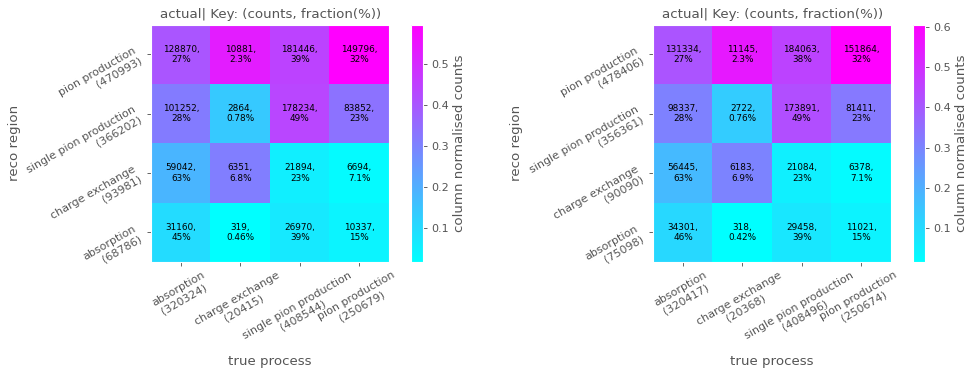

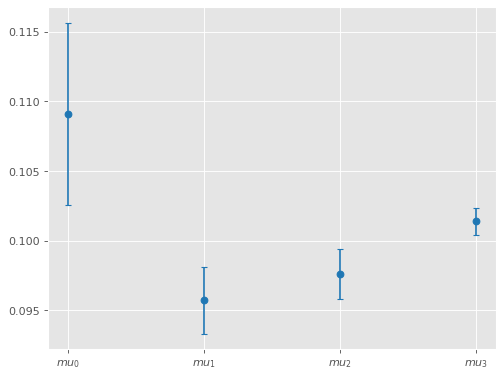

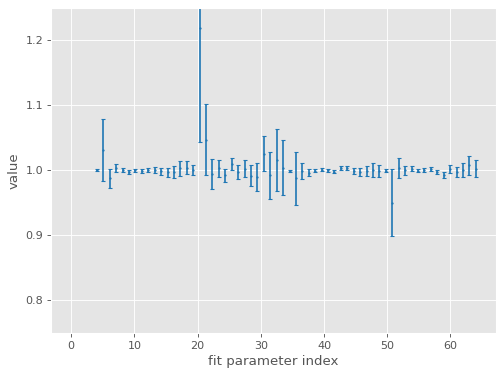

In [33]:
result = cross_section.cabinetry.model_utils.prediction(models["normal"], fit_results = RegionFitToyStudy(toy_observed, models["normal"], energy_slice, None))

In [21]:
model_1_bin = cross_section.RegionFit.CreateModel(ai_template, energy_slice, None, mc_stat_unc = True, single_bin = True)

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]


n_int=[320324]
n_int=[20415]
n_int=[408544]
n_int=[250679]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697151.30305079])
init_params=False
poi_ind=[0, 1, 2, 3]
parameter=['mu_0', 'mu_1', 'mu_2', 'mu_3']
bestfit=array([0.10514739, 0.09679783, 0.09824982, 0.10124227])
uncertainty=array([0.01059071, 0.00333946, 0.0024182 , 0.00118702])
result=FitResults(bestfit=array([0.10514739, 0.09679783, 0.09824982, 0.10124227, 1.00000036,
       0.99999947, 1.00000027, 0.99999972]), uncertainty=array([0.01059071, 0.00333946, 0.0024182 , 0.00118702, 0.00112425,
       0.00448193, 0.00099435, 0.00126798]), labels=['mu_0', 'mu_1', 'mu_2', 'mu_3', 'channel_0_stat_err[0]', 'channel_1_stat_err[0]', 'channel_2_stat_err[0]', 'channel_3_stat_err[0]'], corr_mat=[[ 1.         -0.90330101 -0.85849813  0.56043244 -0.26000811  0.461541
   0.20933235 -0.12119638]
 [-0.90330101  1.          0.76376792 -0.58162188 

counts_matrix=[[31160, 319, 26970, 10337], [59042, 6351, 21894, 6694], [101252, 2864, 178234, 83852], [128870, 
10881, 181446, 149796]]

total_count_actual, total_count, total_count_err=(999962, 999961.9913484813, 8025.733482112957)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  0.105147  0.096798  0.098250  0.101242
error  0.010591  0.003339  0.002418  0.001187

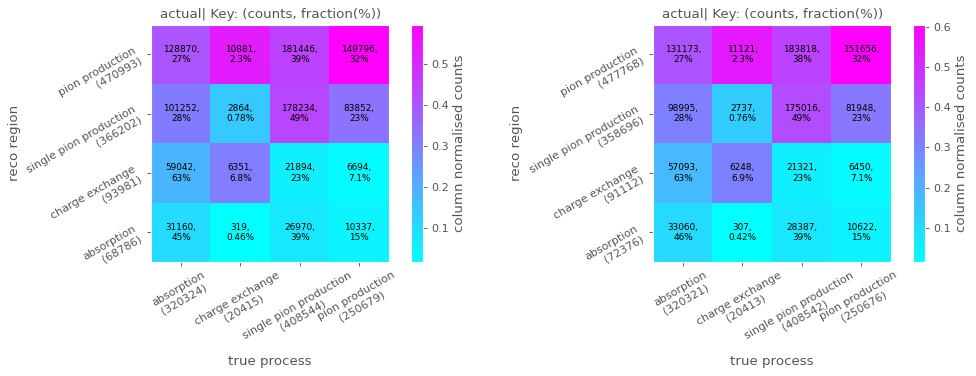

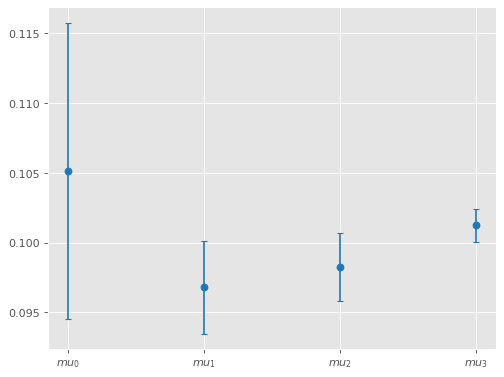

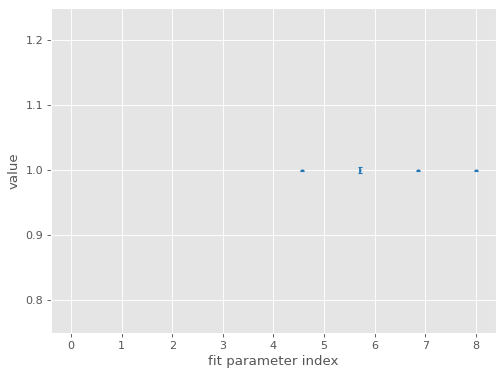

In [34]:
results_1_bin = cross_section.cabinetry.model_utils.prediction(model_1_bin, fit_results = RegionFitToyStudy(toy_observed, model_1_bin, energy_slice, single_bin = True))

In [35]:
toy_observed_ai = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_observed)
true_hists = toy_observed_ai.CreateHistograms(energy_slice, "charge_exchange", False)

In [38]:
bkg, bkg_err = cross_section.RegionFit.EstimateBackgroundInRegions(result, toy_observed_ai)
N_int_ex, N_int_ex_err = cex_analyse.BkgSubRegions(toy_observed_ai, energy_slice, bkg, bkg_err)

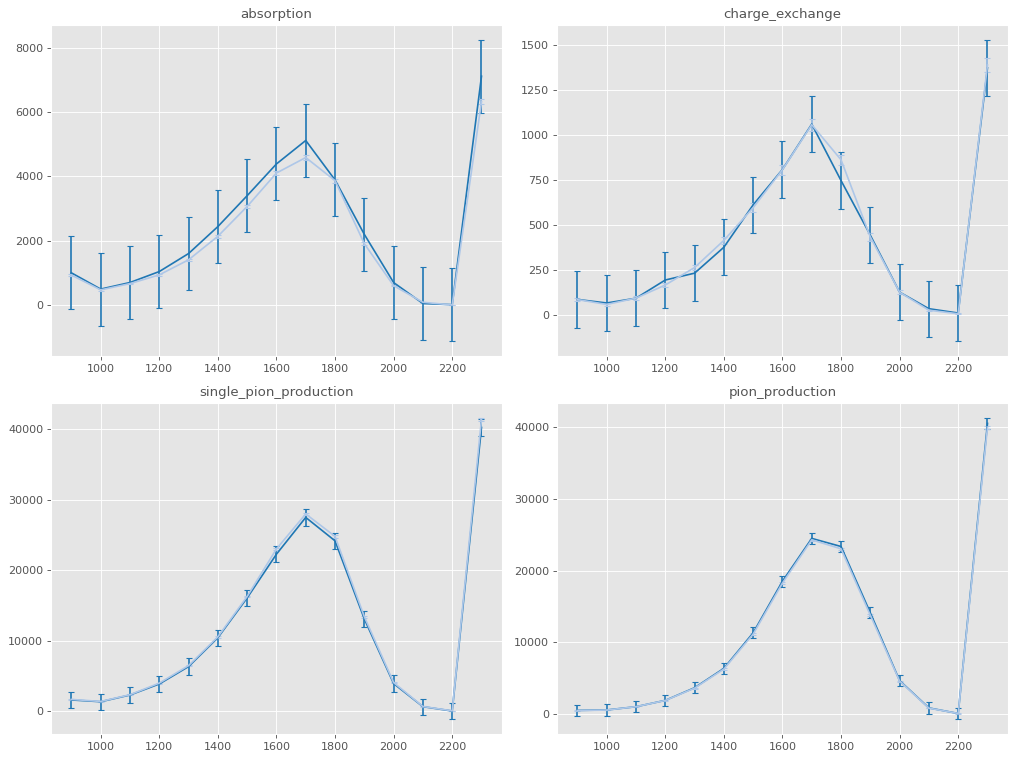

In [39]:
for i, k in Plots.IterMultiPlot(N_int_ex):
    N_int_ex_cheated = toy_observed_ai.NInteract(energy_slice, toy_observed_ai.exclusive_process[k], toy_observed_ai.regions[k])
    Plots.Plot(energy_overflow, N_int_ex[k], yerr = N_int_ex_err[k], title = k, newFigure = False)
    Plots.Plot(energy_overflow, N_int_ex_cheated, yerr = np.sqrt(N_int_ex_cheated), title = k, newFigure = False)


In [25]:
bkg_1_bin = cross_section.RegionFit.EstimateBackgroundOneBin(results_1_bin, model_1_bin, ai_template, energy_slice, "charge_exchange")
bkg_current = cross_section.RegionFit.EstimateBackgroundAllRegions(result, models["normal"], ai_template, "charge_exchange")

In [40]:
reco_hists = toy_observed_ai.CreateHistograms(energy_slice, "charge_exchange", True)
reco_hists_err = {k : np.sqrt(v) for k, v in reco_hists.items()}

reco_hists["int_ex"], reco_hists_err["int_ex"] = cex_analyse.BkgSubAllRegion(toy_observed_ai, energy_slice, bkg_1_bin[0], bkg_1_bin[1])

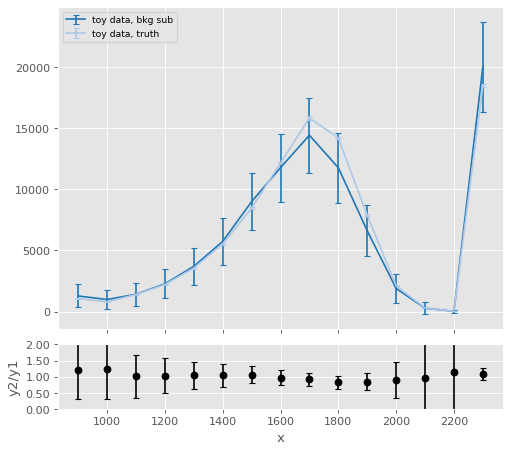

In [41]:
with Plots.RatioPlot(energy_overflow, reco_hists["int_ex"], true_hists["int_ex"], reco_hists_err["int_ex"], np.sqrt(true_hists["int_ex"])) as plot:
    Plots.Plot(plot.x, plot.y1, yerr = plot.y1_err, label = "toy data, bkg sub", newFigure = False)
    Plots.Plot(plot.x, plot.y2, yerr = plot.y2_err, label = "toy data, truth", newFigure = False)

xs_reco_fit_err=array([ 23.66636638,  17.82111865,  12.13622978,   9.59971871,
         8.62913627,   8.50574248,   8.85760466,   9.55265538,
        10.43694225,  11.59320554,  13.28769589,  14.86583797,
        16.88718608,  19.44164011,  23.03958721,  27.98394912,
        35.29228867,  46.44227161,  63.60952502, 129.57968623,
         0.        ,          nan])

(0.0, 327.91921254952456)

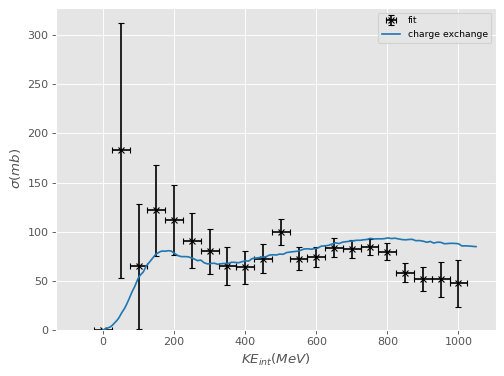

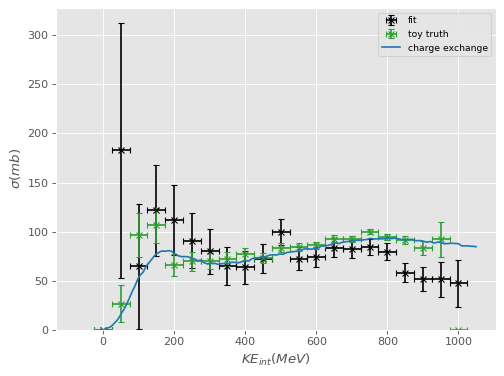

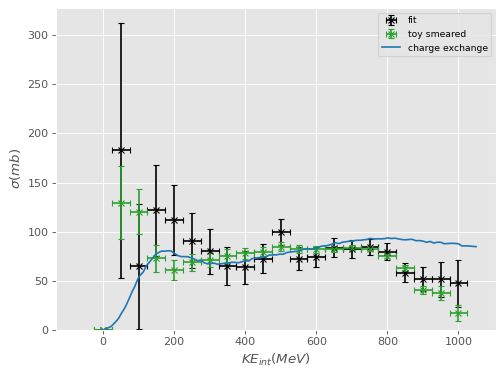

In [32]:
def XSToy(toy : cross_section.Toy, slice_dEdX : np.array, smeared : bool = False):
    KE_int = toy.df.KE_int if smeared is False else toy.df.KE_int_smeared
    KE_init = toy.df.KE_init if smeared is False else toy.df.KE_init_smeared
    outside_tpc = toy.outside_tpc if smeared is False else toy.outside_tpc_smeared

    _, n_interact_inelastic,n_interact_exclusive, n_incident = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.truth_regions[process], energy_slice)

    # n_int_inc, n_inc_inc = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.df.inclusive_process != "decay", energy_slice)
    # n_int_ex = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.truth_regions[process], energy_slice, interact_only = True)
    xs = cross_section.EnergySlice.CrossSection(n_interact_exclusive[1:], n_interact_inelastic[1:], n_incident[1:], slice_dEdX[1:], energy_slice.width)
    output = {"n_interact_exclusive" : n_interact_exclusive, "n_interact_inclusive" : n_interact_inelastic, "n_incident_inclusive" : n_incident, "xs" : xs[0], "xs_err" : xs[1]}
    return output


geant_xs = cross_section.GeantCrossSections(energy_range = energy_range)
slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slice, cross_section.Particle.from_pdgid(211))

xs_true = XSToy(toy_observed, slice_dEdX, False)
xs_reco = XSToy(toy_observed, slice_dEdX, True) # smeared

xs_reco_fit = cross_section.EnergySlice.CrossSection(np.where(KE_int_fit < 0, 0, KE_int_fit)[1:], xs_reco["n_interact_inclusive"][1:], xs_reco["n_incident_inclusive"][1:], slice_dEdX[1:], energy_slice.width)

# xs_reco_fit_err = np.sqrt(np.array(xs_reco_fit[1]**2 + (KE_int_fit_err * xs_reco_fit[0] / KE_int_fit)**2, dtype = float))
xs_reco_fit_err = np.array(KE_int_fit_err[1:] * xs_reco_fit[0] / KE_int_fit[1:], dtype = float) # fit error accounts for statistical uncertainty as well

print(f"{xs_reco_fit_err=}")

x = energy_slice.pos[1:]

# Plots.Plot(x, xs_reco_fit[0][:-1], xerr = energy_slice.width/2, yerr = xs_reco_fit[1][:-1], linestyle = "", marker = "x", color = "black", label = "fit", newFigure = False)
Plots.Plot(x, xs_reco_fit[0], xerr = energy_slice.width/2, yerr = xs_reco_fit_err, linestyle = "", marker = "x", color = "black", label = "fit")
geant_xs.Plot(process)
plt.ylim(0)

Plots.Plot(x, xs_reco_fit[0], xerr = energy_slice.width/2, yerr = xs_reco_fit_err, linestyle = "", marker = "x", color = "black", label = "fit")
Plots.Plot(x, xs_true["xs"], xerr = energy_slice.width/2, yerr = xs_true["xs_err"], linestyle = "", marker = "x", color = "C4", label = "toy truth", newFigure = False)
geant_xs.Plot(process)
plt.ylim(0)

Plots.Plot(x, xs_reco_fit[0], xerr = energy_slice.width/2, yerr = xs_reco_fit_err, linestyle = "", marker = "x", color = "black", label = "fit")
Plots.Plot(x, xs_reco["xs"], xerr = energy_slice.width/2, yerr = xs_reco["xs_err"], linestyle = "", marker = "x", color = "C4", label = "toy smeared", newFigure = False)
geant_xs.Plot(process)
plt.ylim(0)

In [31]:
def weighted_chi_sqr(observed, expected, uncertainties):
    return np.nansum((observed - expected)**2 / uncertainties**2) / len(observed)

sim_curve_interp = cex_toy_generator.interp1d(geant_xs.KE, getattr(geant_xs, process), fill_value = "extrapolate")(x)
weighted_chi_sqrs = {
    "truth": weighted_chi_sqr(xs_true["xs"][:-2], sim_curve_interp, xs_true["xs_err"][:-2]),
    "smeared": weighted_chi_sqr(xs_reco["xs"][:-2], sim_curve_interp, xs_reco["xs_err"][:-2]),
    "fit": weighted_chi_sqr(xs_reco_fit[0][:-1], sim_curve_interp, xs_reco_fit[1][:-1])
}
print(weighted_chi_sqrs)

{'truth': 1.2834386713268517, 'smeared': 20.436367137343048, 'fit': 33.475855250784946}

# Two process model

In [3]:
def TwoSampleKETemplate(toy_template : cross_section.Toy, signal, energy_slices, weights = None):
    signal_mask = toy_template.truth_regions[signal]
    
    templates = []
    for c in toy_template.reco_regions:
        
        templates.append([
            toy_template.NInteract(energy_slices, signal_mask, toy_template.reco_regions[c], weights) + 1,
            toy_template.NInteract(energy_slices, ~signal_mask, toy_template.reco_regions[c], weights) + 1,
            ])
        # analysis_input.NInteract(energy_slices, analysis_input.exclusive_process[s], analysis_input.regions[c], True, analysis_input.weights) + 1
    return templates

def TwoSampleMeanTrackScoreTemplate(toy_template : cross_section.Toy, signal, bins, weights = None):
    templates = []
    signal_mask = toy_template.truth_regions[signal]
    templates = [
        np.histogram(toy_template.df.mean_track_score[signal_mask], bins, weights = weights[signal_mask] if weights is not None else weights)[0],
        np.histogram(toy_template.df.mean_track_score[~signal_mask], bins, weights = weights[~signal_mask] if weights is not None else weights)[0]
    ]
    return np.array(templates)

signal = "charge_exchange"
energy_range = [0, 1000]
energy_slice = cross_section.Slices(50, min(energy_range), max(energy_range), True)

energy_overflow =  np.insert(energy_slice.pos, 0, energy_slice.max_pos + energy_slice.width) # xlabels for KE, which has an overflow bin (max energy + energy bin width) 
energy_bins = np.sort(energy_overflow)

mean_track_score_bins = np.linspace(0, 1, 21, True)

KE_templates = TwoSampleKETemplate(toy_template, signal, energy_slice, None)
mean_track_score_template = TwoSampleMeanTrackScoreTemplate(toy_template, signal, mean_track_score_bins, None)

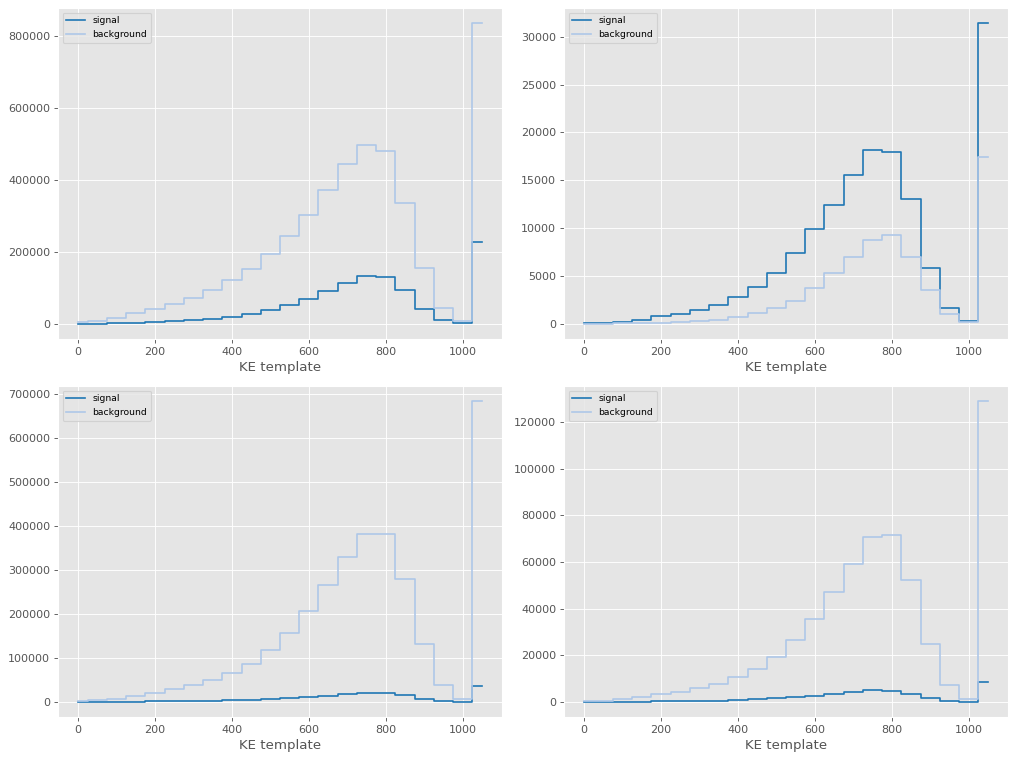

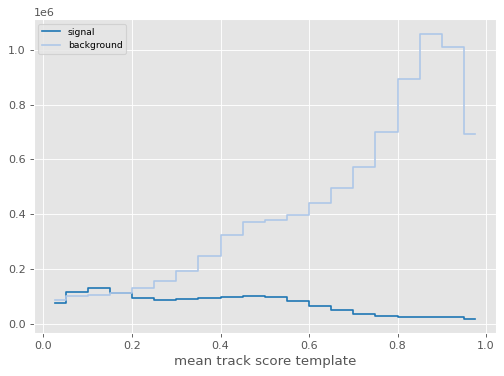

In [4]:
label = ["signal", "background"]
for _, c in Plots.IterMultiPlot(KE_templates):
    for i, s in enumerate(c):
        Plots.Plot(energy_overflow, s, label = label[i], style = "step", newFigure = False, xlabel = "KE template")

Plots.plt.figure()
for i, s in enumerate(mean_track_score_template):
    Plots.Plot(cross_section.bin_centers(mean_track_score_bins), s, style = "step", label = label[i], xlabel = "mean track score template", newFigure = False)

In [5]:
model = cross_section.RegionFit.Model(4, KE_templates, None, False)

In [6]:
analysis_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_template)

In [7]:
cross_section.RegionFit.Fit(cross_section.RegionFit.GenerateObservations(analysis_input, energy_slice, None, model), model)

model.config.suggested_init()=[1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-522.01742143])
init_params=None
poi_ind=[0, 1]
parameter=['mu_0', 'mu_1']
bestfit=array([0.99984884, 1.00000527])
uncertainty=array([0.00253469, 0.00053665])
result=FitResults(bestfit=array([0.99984884, 1.00000527]), uncertainty=array([0.00253469, 0.00053665]), labels=['mu_0', 'mu_1'], corr_mat=[[ 1.         -0.72591833]
 [-0.72591833  1.        ]], best_twice_nll=1044.0288024236856, goodness_of_fit=-1, minos_uncertainty={})


FitResults(bestfit=array([0.99984884, 1.00000527]), uncertainty=array([0.00253469, 0.00053665]), labels=['mu_0', 'mu_1'], corr_mat=[[ 1.         -0.72591833]
 [-0.72591833  1.        ]], best_twice_nll=1044.0288024236856, goodness_of_fit=-1, minos_uncertainty={})

In [8]:
def PlotFitResults2Samp(xlabel, model : cross_section.pyhf.Model, toy_template : cross_section.Toy, results, true_counts, pdf : Plots.PlotBook = Plots.PlotBook.null):
    colours = {
        "absorption"      : "#777777",
        "charge_exchange" : "#8EBA42",
        "single_pion_production" : "#E24A33",
        "pion_production" : "#988ED5",
    }

    scale_factors = {k : sum(true_counts[k].values()) / sum(toy_template.df.total_inelastic) for k in true_counts}
    x = list(range(len(results)))

    mu = []
    mu_err = []
    for k in results:
        mu.append(results[k].bestfit[0:2] / scale_factors[k])
        mu_err.append(results[k].uncertainty[0:2] / scale_factors[k])
    mu = np.array(mu)
    mu_err = np.array(mu_err)

    process_map = {0 : "sig", 1 : "bkg"}

    # Plot the fit value for each scale factor 
    plt.figure()
    for i in range(2):
        Plots.Plot(x, mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{{{process_map[i]}}}$", marker = "o", ylabel = "fit value", color = list(colours.values())[i], linestyle = "")
    Plots.plt.xticks(ticks = x, labels = results.keys())
    Plots.plt.xlabel(xlabel)
    pdf.Save()

    # same as above, in separate plots
    for i in Plots.MultiPlot(2):
        Plots.Plot(x, mu[:, i], yerr = mu_err[:, i], newFigure = False, title = f"$\mu_{{{process_map[i]}}}$", marker = "o", xlabel = xlabel, ylabel = "fit value", color = list(colours.values())[i], linestyle = "")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()


    true_counts_samp = []
    true_counts_pred_res = []
    true_counts_pred_res_err = []
    for k, v in results.items():
        true_counts_sig = true_counts[k]["charge_exchange"]
        true_counts_bkg = sum([true_counts[k][i] for i in true_counts[k] if i != "charge_exchange"])
        counts_2samp = np.array([true_counts_sig, true_counts_bkg])

        post_fit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = v, label = "post-fit")

        if any([c["name"] == "mean_track_score" for c in post_fit_pred.model.spec["channels"]]):
            post_fit_pred = cross_section.RegionFit.SliceModelPrediction(post_fit_pred, slice(-1), "KE_int_postfit") # exclude the channel which is the mean track score
        else:
            post_fit_pred = cross_section.RegionFit.SliceModelPrediction(post_fit_pred, slice(0, len(post_fit_pred.model_yields)), "KE_int_postfit")

        true_counts_samp.append(counts_2samp)
        true_counts_pred_res.append(np.sum([np.sum(i, 1) for i in post_fit_pred.model_yields], 0) - counts_2samp)

        true_counts_pred_res_err.append(np.sum(post_fit_pred.total_stdev_model_channels, 0)[:-1])
        # true_counts_pred_res[k] = {toy_template.truth_region_labels[j] : int(np.sum([post_fit_pred.model_yields[i][j] for i in range(len(toy_template.reco_region_labels))])) - true_counts[k][toy_template.truth_region_labels[j]] for j in range(len(toy_template.truth_region_labels))}


    true_counts_samp = np.array(true_counts_samp).T
    true_counts_pred_res = np.array(true_counts_pred_res).T
    true_counts_pred_res_err = np.array(true_counts_pred_res_err).T

    print(f"{true_counts_samp=}")
    print(f"{true_counts_pred_res=}")

    prefit_counts = [model.main_model.expected_data(np.array(model.config.suggested_init()) * scale_factors[k], return_by_sample = True) for k in scale_factors]

    if "mean_track_score" in model.config.channels:
        prefit_counts = [i[:, :-model.config.channel_nbins["mean_track_score"]] for i in prefit_counts]
    prefit_counts = np.array([np.sum(i, 1) for i in prefit_counts]).T

    print(prefit_counts)

    # plot true process residual
    for i in Plots.MultiPlot(len(true_counts_pred_res)):
        Plots.Plot(x, true_counts_pred_res[i], yerr = true_counts_pred_res_err[i], title = f"$N_{{{process_map[i]}}}^{{pred}}$", xlabel = xlabel, ylabel = "residual", linestyle = "", marker = "o", color = list(colours.values())[i], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    # plot true process fractional error
    for i in Plots.MultiPlot(len(true_counts_pred_res)):
        Plots.Plot(x, true_counts_pred_res[i] / true_counts_samp[i], yerr = true_counts_pred_res_err[i] / true_counts_samp[i], title = f"measured $N_{{{process_map[i]}}}$", xlabel = xlabel, ylabel = "fractional error", linestyle = "", marker = "o", color = list(colours.values())[i], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    # plot true process fractional error
    for i in Plots.MultiPlot(len(true_counts_pred_res)):
        Plots.Plot(x, true_counts_pred_res[i] / true_counts_samp[i], yerr = true_counts_pred_res_err[i] / true_counts_samp[i], title = f"$N_{{{process_map[i]}}}$", xlabel = xlabel, ylabel = "fractional error", linestyle = "", marker = "o", color = list(colours.values())[i], label = "measured", newFigure = False)
        Plots.Plot(x, (prefit_counts[i] - true_counts_samp[i]) / true_counts_samp[i], title = f"$N_{{{process_map[i]}}}$", linestyle = "", marker = "o", color = "k", label = "prefit", newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()

    # plot true process fractional error
    Plots.plt.figure()
    for i in range(len(true_counts_pred_res)):
        Plots.Plot(x, true_counts_pred_res[i] / true_counts_samp[i], yerr = true_counts_pred_res_err[i] / true_counts_samp[i], label = f"${process_map[i]}$", xlabel = xlabel, ylabel = "fractional error", linestyle = "", marker = "o", color = list(colours.values())[i], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        plt.ylim(-1, 1)
    Plots.plt.xticks(ticks = x, labels = results.keys())
    pdf.Save()


In [11]:
folder = {
    'absorption': "abs",
    'quasielastic': "quasi",
    'charge_exchange': "cex",
    'double_charge_exchange': "dcex",
    'pion_production': "pip"
}

for target in folder:
    print(target)

    results = {}
    true_counts = {}
    expected_mus = {}
    directory = f"test/region_fit_tests_2samp/"
    scales = {
        'absorption': 1,
        'quasielastic': 1,
        'charge_exchange': 1,
        'double_charge_exchange': 1,
        'pion_production': 1
        }
    config = CreateConfig(scale_factors = scales, seed = 1, events = 1E6)
    for i in [0.25, 0.5, 0.8, 0.9, 1, 1.1, 1.2, 1.5, 2]:
        scales[target] = i
        results[i], true_counts[i], expected_mus[i] = ModifiedConfigTest(config, energy_slice, model, toy_template, None, None)
        clear_output()
        print(target)
    
    cross_section.SaveObject(f"{directory}fit_results_{folder[target]}.dill", {"results" : results, "true_counts" : true_counts, "expected_mus" : expected_mus}) # keep results for future reference
    with Plots.PlotBook(f"{directory}fit_results_{folder[target]}.pdf", True) as pdf:
      PlotFitResults2Samp(f"{target} normalisation", model, toy_template, results, true_counts, pdf)
    Plots.plt.close("all")

pion_production

pdf test/region_fit_tests_2samp/fit_results_pip.pdf has been opened


true_counts_samp=array([[167937, 160128, 152579, 149797, 147544, 145441, 143127, 136687,
        127142],
       [825070, 832879, 840428, 843210, 845463, 847566, 849880, 856320,
        865865]])

true_counts_pred_res=array([[-7965.48261865, -5610.6318463 , -2241.55669965, -1484.78224257,
         -501.77544377,   499.75263454,  1432.0571449 ,  3060.36798682,
         6736.46990761],
       [ 7965.49708698,  5610.63191947,  2241.5579933 ,  1484.78216653,
          501.77549875,  -499.75260124, -1432.0571188 , -3060.31264888,
        -6736.59918402]])

[[146004.42716327 146004.42716327 146004.42716327 146004.42716327
  146004.42716327 146004.42716327 146004.42716327 146004.42716327
  146004.42716327]
 [847014.77527105 847014.77527105 847014.77527105 847014.77527105
  847014.77527105 847014.77527105 847014.77527105 847014.77527105
  847014.77527105]]

pdf test/region_fit_tests_2samp/fit_results_pip.pdf has been closed


# ABCD Method

In [ ]:
def ABCDModel(samples : np.array):
    channels = [
        {
            "name": f"channel_0",
            "samples":[
                {
                    "name" : f"sig_A",
                    "data" : samples[0][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_A",
                    "data" : samples[0][1].tolist(),
                    "modifiers" : [
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][1]).astype(int).tolist()}
                        ]
                },

            ]
        },
        {
            "name": f"channel_1",
            "samples":[
                {
                    "name" : f"sig_B",
                    "data" : samples[1][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_B",
                    "data" : samples[1][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_2",
            "samples":[
                {
                    "name" : f"sig_C",
                    "data" : samples[2][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_C",
                    "data" : samples[2][1].tolist(),
                    "modifiers" : [
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_3",
            "samples":[
                {
                    "name" : f"sig_D",
                    "data" : samples[3][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_D",
                    "data" : samples[3][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
    ]
    spec = {"channels" : channels}
    model = cross_section.pyhf.Model(spec, poi_name = "mu_sig")
    return model

def CreateModelInputDataABCD(toy : cross_section.Toy, signal : str, bins : np.array):
    samples_binned = []
    for r in toy.reco_regions:
        samples = []
        for t in toy.truth_regions:
            if t == "charge_exchange":
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & toy.truth_regions[t]], bins)[0])
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & ~toy.truth_regions[t]], bins)[0])
        samples_binned.append(samples)
    return samples_binned


def CreateObservedInputData(toy : cross_section.Toy, energy_bins : np.array, alt_regions : pd.DataFrame = None):
    toy_observed_binned = []

    reco_regions = toy.df.filter(regex = "reco_regions") if alt_regions is None else alt_regions.columns 

    for c in reco_regions:
        m = toy.df[c] if alt_regions is None else alt_regions[c]
        toy_observed_binned.append(np.histogram(toy.df.KE_int_smeared[m], bins = energy_bins)[0])
    if mean_track_score_bins is not None:
        toy_observed_binned.append(np.histogram(toy.df.mean_track_score[toy.df.inclusive_process != "decay"], mean_track_score_bins)[0])
    return toy_observed_binned


def ABCD_MLEScan(toy, model, bins, poi_ind : int, params : np.array):
    observations = cross_section.RegionFit.GenerateObservations(CreateObservedInputData(toy, bins, toy.reco_regions), model)
    # params = np.array(params)
    p = np.linspace(0, 2, 101)
    nll = []
    for i in p:
        params_new = np.array(params)
        params_new[poi_ind] = i
        nll.append(-2 * model.logpdf(params_new, observations)[0])

    Plots.Plot(p, nll, xlabel = model.config.par_names[poi_ind], ylabel = "$-2\ln(L)$", newFigure = False)
    min_ind = np.argmin(nll)
    Plots.Plot(p[min_ind], nll[min_ind], marker = "x", newFigure = False, label = f"minimum | {model.config.par_names[poi_ind]}={p[min_ind]:.3g}, $-2\ln(L)$={nll[min_ind]:.3g}", color = "black")


def ABCD_Study(toy_model : cross_section.Toy, toy_obs : cross_section.Toy, pdf : Plots.PlotBook):
    bins = np.linspace(0, 1050, 22)
    model_alt = ABCDModel(CreateModelInputDataABCD(toy_model, bins))
    observed = cross_section.RegionFit.GenerateObservations(CreateObservedInputData(toy_obs, bins, toy_obs.reco_regions), model_alt)
    result = cross_section.RegionFit.Fit(observed, model_alt, False)

    prefit_pred = cross_section.cabinetry.model_utils.prediction(model_alt)
    postfit_pred = cross_section.cabinetry.model_utils.prediction(model_alt, fit_results = result)
    print(result)

    true_counts = cross_section.Toy.ComputeCounts(toy_obs.truth_regions, toy_obs.reco_regions)
    Plots.PlotConfusionMatrix(true_counts, toy_obs.truth_region_labels, toy_obs.reco_region_labels, x_label = "true process", y_label = "reco region")
    pdf.Save()

    titles = toy_model.reco_region_labels

    x = (bins[1:] + bins[:-1]) / 2
    for n, (i, j) in Plots.IterMultiPlot(list(zip(prefit_pred.model_yields, postfit_pred.model_yields))):
        Plots.Plot(x, i[4 + n], label = "prefit signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n].replace("_", " "), newFigure = False)
        Plots.Plot(x, i[n], label = "prefit bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    actual_yield = CreateModelInputDataABCD(toy_obs, bins)
    for n, (i, j, k) in Plots.IterMultiPlot(list(zip(actual_yield, postfit_pred.model_yields, postfit_pred.total_stdev_model_bins))):
        Plots.Plot(x, i[0], label = "actual signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n], newFigure = False)
        Plots.Plot(x, i[1], label = "actual bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], yerr = k[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], yerr = k[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    for i in Plots.MultiPlot(4):
        ABCD_MLEScan(toy_obs, model_alt, bins, i, model_alt.config.suggested_init())
    pdf.Save()
    return

In [ ]:
pdf_valid = Plots.PlotBook("toy_ABCD_valid.pdf", True)
ABCD_Study(toy_template, toy_template, pdf_valid)
pdf_valid.close()

In [ ]:
pdf_vary = Plots.PlotBook("toy_ABCD_vary_regions.pdf", True)
ABCD_Study(toy_template, toy_alt, pdf_vary)
pdf_vary.close()